In [113]:
import sys
print(sys.executable)

/home/robertalamberti/HPC-project/.venv/bin/python


In [114]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [115]:
# Partiamo dalla cartella che contiene analysis.ipynb
BASE_DIR = os.getcwd()  # es: /home/robertalamberti/HPC-PROJECT/ex1

# Funzione di utilità per caricare tutti i csv in una sottocartella mode ('fixed' o 'varied')
def load_csvs(root_dir, mode):
    """
    root_dir: es. '/…/scripts/bcast' o '/…/scripts/scatter'
    mode: 'fixed' o 'varied'
    restituisce dict { chiave: DataFrame }
    dove chiave = nome del file senza estensione
    """
    csv_dir = os.path.join(root_dir, mode, 'csv')
    assert os.path.isdir(csv_dir), f"{csv_dir} non trovato"
    d = {}
    for fname in sorted(os.listdir(csv_dir)):
        if fname.endswith('.csv'):
            key  = os.path.splitext(fname)[0]
            path = os.path.join(csv_dir, fname)
            d[key] = pd.read_csv(path)
    return d

# ----- bcast -----
BCAST_ROOT   = os.path.join(BASE_DIR, 'scripts', 'bcast')
bcast_fixed  = load_csvs(BCAST_ROOT, 'fixed')
bcast_varied = load_csvs(BCAST_ROOT, 'varied')

print("bcast fixed keys:",  list(bcast_fixed.keys()))
print("bcast varied keys:", list(bcast_varied.keys()))

# ----- scatter -----
SCATTER_ROOT   = os.path.join(BASE_DIR, 'scripts', 'scatter')
scatter_fixed  = load_csvs(SCATTER_ROOT, 'fixed')
scatter_varied = load_csvs(SCATTER_ROOT, 'varied')

print("scatter fixed keys:",  list(scatter_fixed.keys()))
print("scatter varied keys:", list(scatter_varied.keys()))



bcast fixed keys: ['bcast0_fixed_core', 'bcast1_fixed_core', 'bcast3_fixed_core', 'bcast5_fixed_core']
bcast varied keys: ['bcast0_core_mapping_genoa', 'bcast1_core_mapping_genoa', 'bcast3_core_mapping_genoa', 'bcast5_core_mapping_genoa']
scatter fixed keys: ['scatter0_fixed_core', 'scatter1_fixed_core', 'scatter2_fixed_core', 'scatter3_fixed_core']
scatter varied keys: ['scatter0_core_mapping', 'scatter1_core_mapping', 'scatter2_core_mapping', 'scatter3_core_mapping']


In [116]:
def log_transform_diff(diff):
    return np.sign(diff) * np.log1p(np.abs(diff)) / np.log(10)


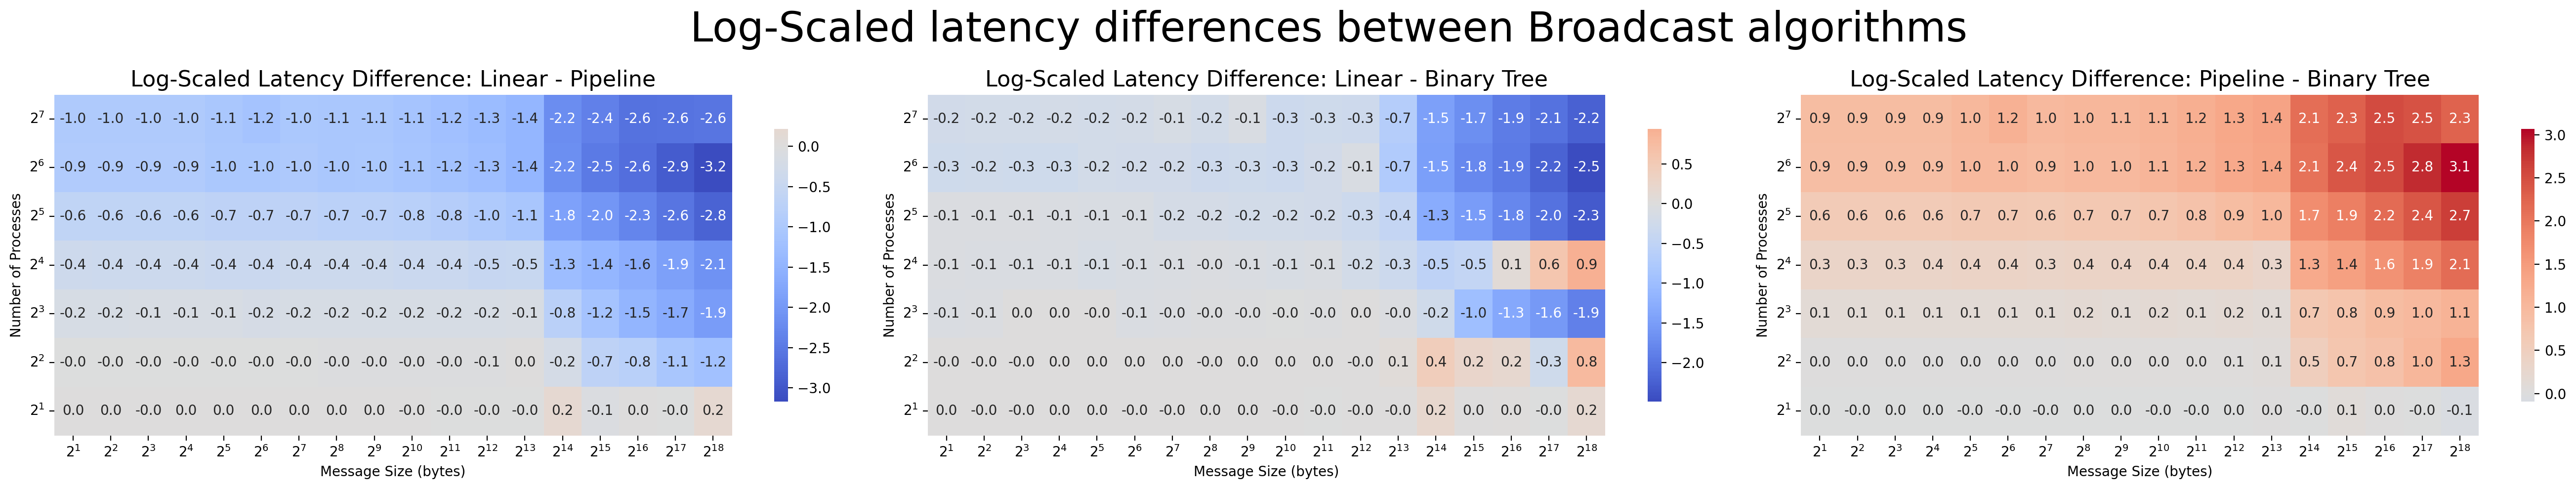

In [117]:
## LOG LATENCY DIFFERENCES BETWEEN BROADCAST ALGORITHM

# Sostituisci tutti i pd.read_csv con i tuoi dict!
df_b_map0 = bcast_varied['bcast0_core_mapping_genoa']     # default
df_b_map1 = bcast_varied['bcast1_core_mapping_genoa']    # basic linear
df_b_map3 = bcast_varied['bcast3_core_mapping_genoa']    # pipeline
df_b_map5 = bcast_varied['bcast5_core_mapping_genoa']    # binary tree

# Ordina PRIMA del merge
#df_b_map0 = bcast_varied['bcast0_core_mapping_genoa'].sort_values(by='Processes')
#df_b_map1 = bcast_varied['bcast1_core_mapping_genoa'].sort_values(by='Processes')
#df_b_map3 = bcast_varied['bcast3_core_mapping_genoa'].sort_values(by='Processes')
#df_b_map5 = bcast_varied['bcast5_core_mapping_genoa'].sort_values(by='Processes')

# Merge
merged_df = df_b_map1.merge(df_b_map3, on=['Processes', 'Size'], suffixes=('_linear', '_pipeline'))
merged_df = merged_df.merge(df_b_map5, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_binary_tree'})

# Differenze log
merged_df['linear_vs_pipeline'] = log_transform_diff(merged_df['Latency_linear'] - merged_df['Latency_pipeline'])
merged_df['linear_vs_binary_tree'] = log_transform_diff(merged_df['Latency_linear'] - merged_df['Latency_binary_tree'])
merged_df['pipeline_vs_binary_tree'] = log_transform_diff(merged_df['Latency_pipeline'] - merged_df['Latency_binary_tree'])

# Pivot
pivot_linear_pipeline = merged_df.pivot(index='Processes', columns='Size', values='linear_vs_pipeline')
pivot_linear_binary = merged_df.pivot(index='Processes', columns='Size', values='linear_vs_binary_tree')
pivot_pipeline_binary = merged_df.pivot(index='Processes', columns='Size', values='pipeline_vs_binary_tree')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(27, 5), dpi=200)
cbar_kws = {'shrink': 0.8}

# Linear - Pipeline
sns.heatmap(pivot_linear_pipeline, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[0], cbar_kws=cbar_kws)
axes[0].set_title('Log-Scaled Latency Difference: Linear - Pipeline', size=16)
axes[0].set_xlabel('Message Size (bytes)')
axes[0].set_ylabel('Number of Processes')

# Linear - Binary Tree
sns.heatmap(pivot_linear_binary, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[1], cbar_kws=cbar_kws)
axes[1].set_title('Log-Scaled Latency Difference: Linear - Binary Tree', size=16)
axes[1].set_xlabel('Message Size (bytes)')
axes[1].set_ylabel('Number of Processes')

# Pipeline - Binary Tree
sns.heatmap(pivot_pipeline_binary, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[2], cbar_kws=cbar_kws)
axes[2].set_title('Log-Scaled Latency Difference: Pipeline - Binary Tree', size=16)
axes[2].set_xlabel('Message Size (bytes)')
axes[2].set_ylabel('Number of Processes')

# Powers of 2 e invert y
for ax in axes:
    ax.invert_yaxis()
    x_ticks = pivot_linear_pipeline.columns
    y_ticks = pivot_linear_pipeline.index
    ax.set_xticks(np.arange(len(x_ticks)) + 0.5)
    ax.set_yticks(np.arange(len(y_ticks)) + 0.5)
    ax.set_xticklabels([f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
    ax.set_yticklabels([f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

plt.suptitle('Log-Scaled latency differences between Broadcast algorithms', fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'plots', 'log_scaled_heatmap_broadcast.png'))
plt.show()

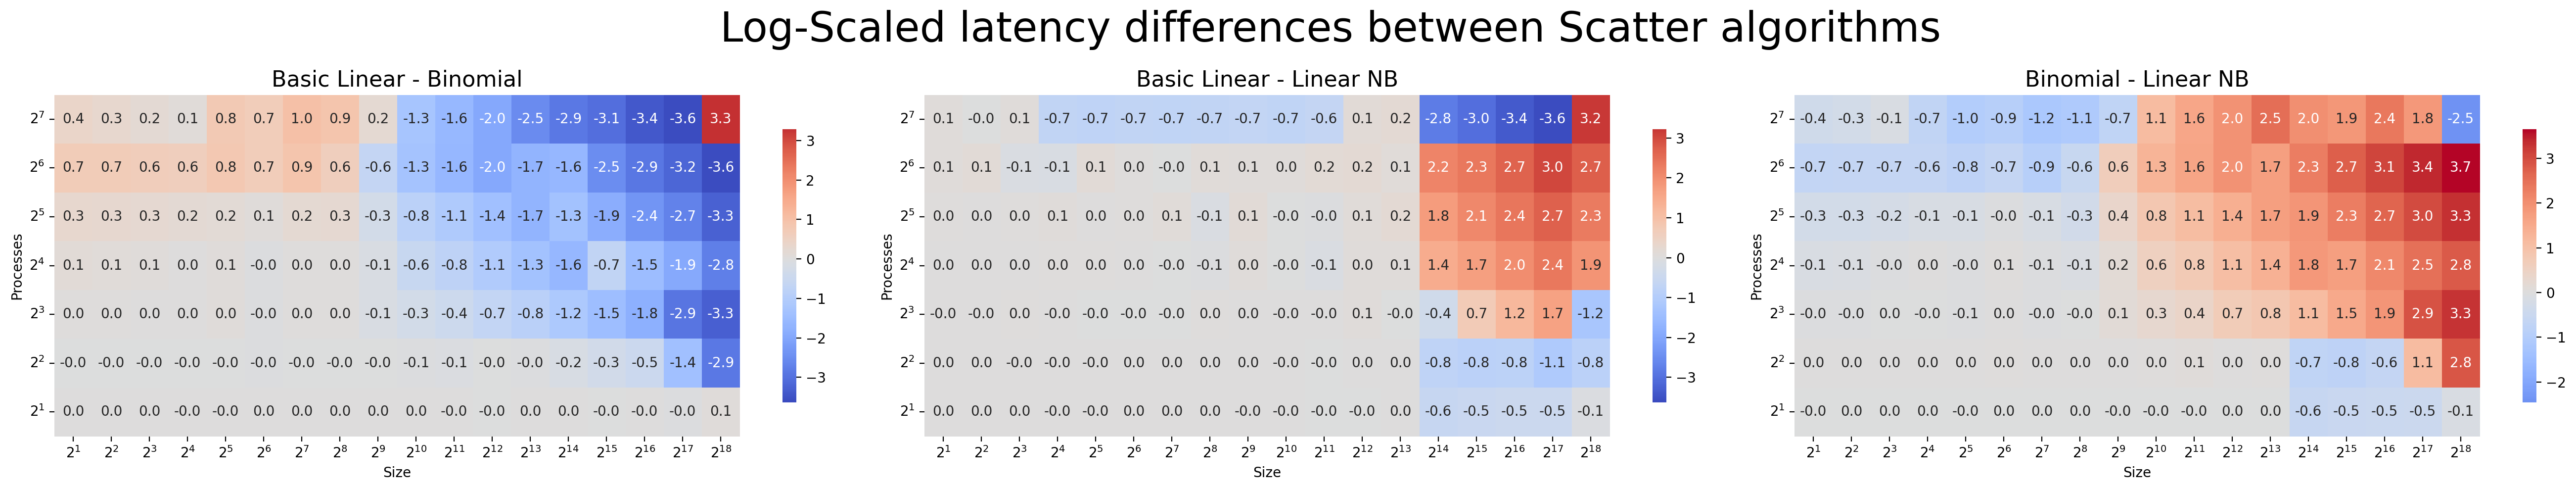

In [118]:
## LOG LATENCY DIFFERENCES BETWEEN SCATTER ALGORITHMS
df_s_map0 = scatter_varied['scatter0_core_mapping'] #default
df_s_map1 = scatter_varied['scatter1_core_mapping']   # basic linear
df_s_map2 = scatter_varied['scatter2_core_mapping']   # binomial
df_s_map3 = scatter_varied['scatter3_core_mapping']   # linear_nb

merged_df = df_s_map1.merge(df_s_map2, on=['Processes', 'Size'], suffixes=('_basic_linear', '_binomial'))
merged_df = merged_df.merge(df_s_map3, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_linear_nb'})

merged_df['basic_linear_vs_binomial'] = log_transform_diff(merged_df['Latency_basic_linear'] - merged_df['Latency_binomial'])
merged_df['basic_linear_vs_linear_nb'] = log_transform_diff(merged_df['Latency_basic_linear'] - merged_df['Latency_linear_nb'])
merged_df['binomial_vs_linear_nb'] = log_transform_diff(merged_df['Latency_binomial'] - merged_df['Latency_linear_nb'])

pivot_basic_linear_binomial = merged_df.pivot(index='Processes', columns='Size', values='basic_linear_vs_binomial')
pivot_basic_linear_linear_nb = merged_df.pivot(index='Processes', columns='Size', values='basic_linear_vs_linear_nb')
pivot_binomial_linear_nb = merged_df.pivot(index='Processes', columns='Size', values='binomial_vs_linear_nb')

fig, axes = plt.subplots(1, 3, figsize=(27, 5), dpi=200)
cbar_kws = {'shrink': 0.8}

sns.heatmap(pivot_basic_linear_binomial, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[0], cbar_kws=cbar_kws)
axes[0].set_title('Basic Linear - Binomial', size=16)
sns.heatmap(pivot_basic_linear_linear_nb, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[1], cbar_kws=cbar_kws)
axes[1].set_title('Basic Linear - Linear NB', size=16)
sns.heatmap(pivot_binomial_linear_nb, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[2], cbar_kws=cbar_kws)
axes[2].set_title('Binomial - Linear NB', size=16)

for ax in axes:
    ax.invert_yaxis()
    x_ticks = pivot_basic_linear_binomial.columns
    y_ticks = pivot_basic_linear_binomial.index
    ax.set_xticks(np.arange(len(x_ticks)) + 0.5)
    ax.set_yticks(np.arange(len(y_ticks)) + 0.5)
    ax.set_xticklabels([f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
    ax.set_yticklabels([f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

plt.suptitle('Log-Scaled latency differences between Scatter algorithms', fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'plots', 'log_scaled_heatmap_scatter.png'))
plt.show()

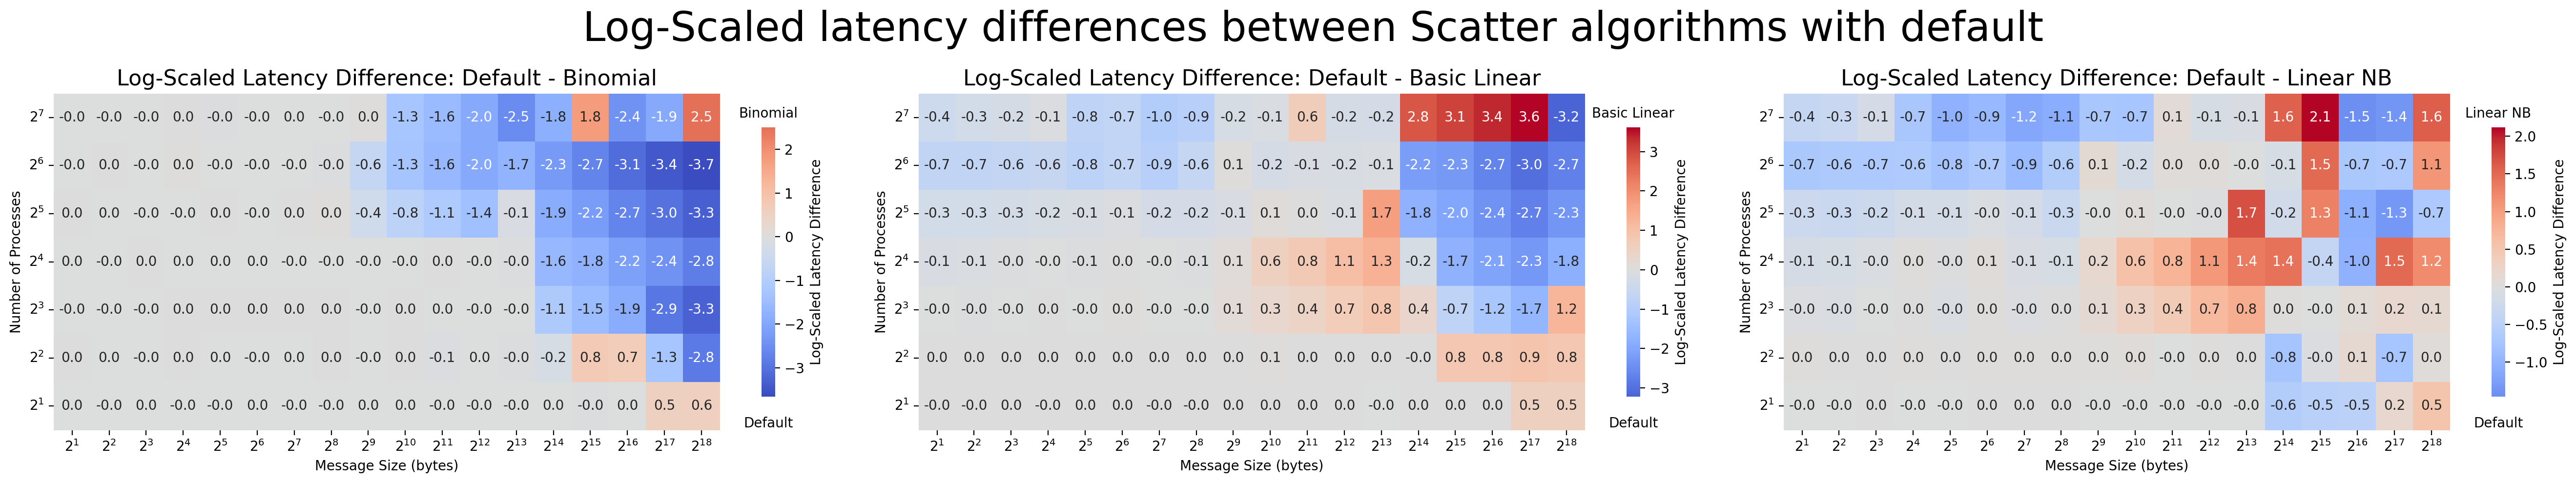

In [119]:
# Merge datasets on Processes and Size
merged_df = df_s_map1.merge(df_s_map2, on=['Processes', 'Size'], suffixes=('_basic_linear', '_binomial'))
merged_df = merged_df.merge(df_s_map3, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_linear_nb'})
merged_df = merged_df.merge(df_s_map0, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_default'})

merged_df['default_vs_binomial'] = log_transform_diff(merged_df['Latency_default'] - merged_df['Latency_binomial'])
merged_df['default_vs_linear_nb'] = log_transform_diff(merged_df['Latency_default'] - merged_df['Latency_linear_nb'])
merged_df['default_vs_basic_linear'] = log_transform_diff(merged_df['Latency_default'] - merged_df['Latency_basic_linear'])

# Create pivot tables for each comparison to use in the heatmap
pivot_default_binomial = merged_df.pivot(index='Processes', columns='Size', values='default_vs_binomial')
pivot_default_linear_nb = merged_df.pivot(index='Processes', columns='Size', values='default_vs_linear_nb')
pivot_default_basic_linear = merged_df.pivot(index='Processes', columns='Size', values='default_vs_basic_linear')

# Define a color map with a centered color at zero for logarithmic scale
fig, axes = plt.subplots(1, 3, figsize=(27, 5), dpi=200)

# Plot each comparison with a logarithmic scale
cbar_kws = {'shrink': 0.8}  # Optionally adjust the size of the color bar

# Plot each comparison with a logarithmic scale
heatmap1 = sns.heatmap(
    pivot_default_binomial,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar_kws=cbar_kws
)
cbar = heatmap1.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')  # Label beside the color bar
cbar.ax.text(0.5, 1.05, 'Binomial', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Default', ha='center', va='center', transform=cbar.ax.transAxes)
axes[0].set_title('Log-Scaled Latency Difference: Default - Binomial', size=16)
axes[0].set_xlabel('Message Size (bytes)')
axes[0].set_ylabel('Number of Processes')


heatmap2 = sns.heatmap(
    pivot_default_basic_linear,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[1],
    cbar_kws=cbar_kws
)
cbar = heatmap2.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')  # Label beside the color bar
cbar.ax.text(0.5, 1.05, 'Basic Linear', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Default', ha='center', va='center', transform=cbar.ax.transAxes)
axes[1].set_title('Log-Scaled Latency Difference: Default - Basic Linear', size=16)
axes[1].set_xlabel('Message Size (bytes)')
axes[1].set_ylabel('Number of Processes')

heatmap3 = sns.heatmap(
    pivot_default_linear_nb,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[2],
    cbar_kws=cbar_kws
)
cbar = heatmap3.collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')  # Label beside the color bar
cbar.ax.text(0.5, 1.05, 'Linear NB', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Default', ha='center', va='center', transform=cbar.ax.transAxes)
axes[2].set_title('Log-Scaled Latency Difference: Default - Linear NB', size=16)
axes[2].set_xlabel('Message Size (bytes)')
axes[2].set_ylabel('Number of Processes')

# Invert the y-axis for each subplot and set x and y ticks as powers of 2
for ax in axes:
    ax.invert_yaxis()
    
    # Set x and y ticks to powers of 2
    x_ticks = pivot_basic_linear_binomial.columns
    y_ticks = pivot_basic_linear_binomial.index
    
    ax.set_xticks(np.arange(len(x_ticks)) + 0.5)
    ax.set_yticks(np.arange(len(y_ticks)) + 0.5)
    
    ax.set_xticklabels([f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
    ax.set_yticklabels([f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

out_dir = os.path.join(BASE_DIR, 'plots')
os.makedirs(out_dir, exist_ok=True)  # Crea la cartella se non esiste

plt.savefig(os.path.join(out_dir, 'log_scaled_heatmap_scatter_default.png'))

plt.suptitle('Log-Scaled latency differences between Scatter algorithms with default', fontsize=30)

plt.tight_layout()

plt.savefig(f'{out_dir}log_scaled_heatmap_scatter_default.png')
plt.show()


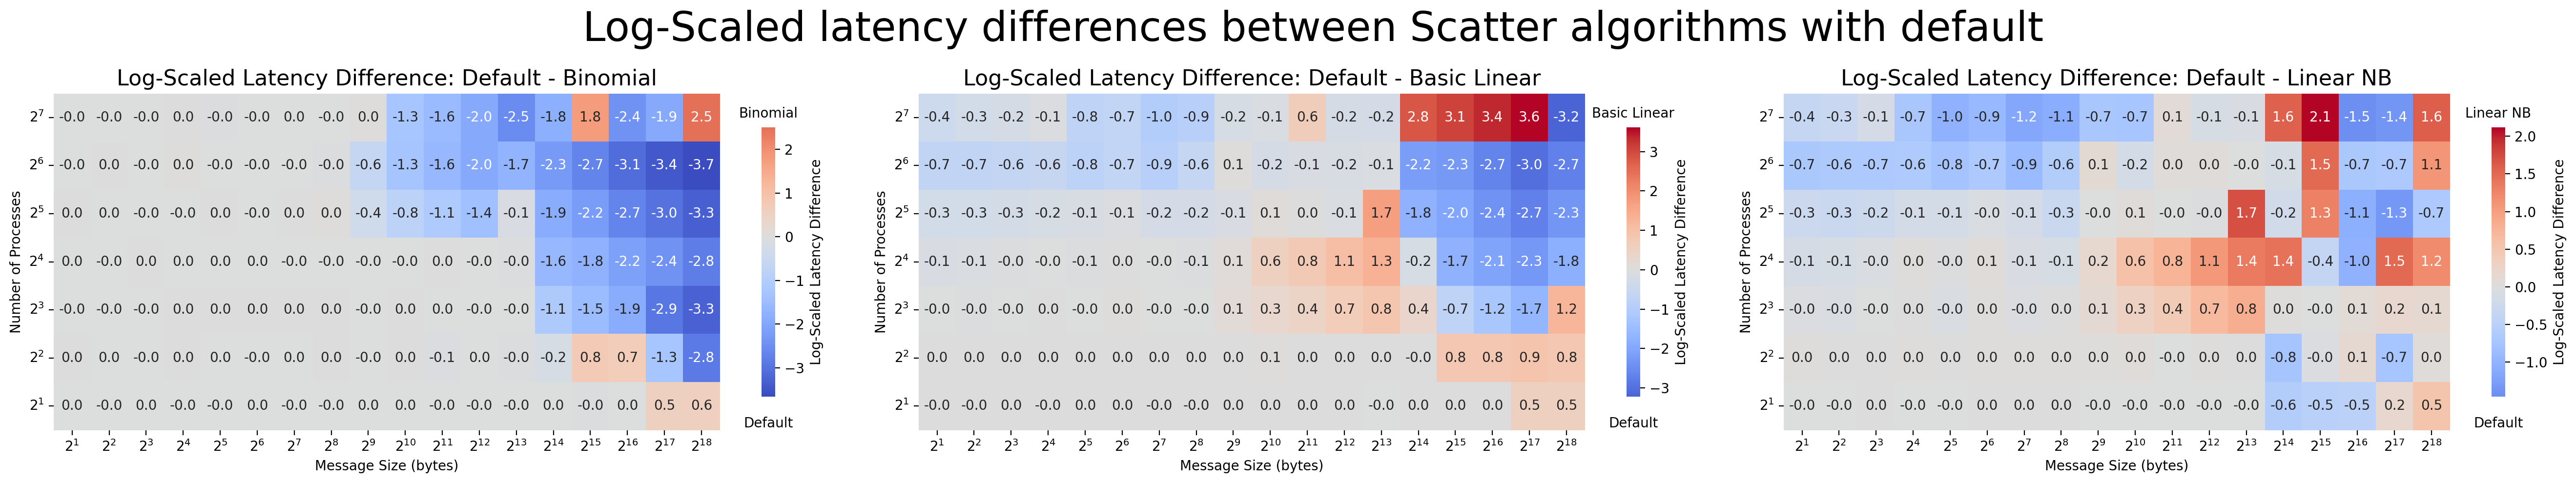

In [120]:
df_s_map0 = scatter_varied['scatter0_core_mapping']  # default
df_s_map1 = scatter_varied['scatter1_core_mapping']  # basic linear
df_s_map2 = scatter_varied['scatter2_core_mapping']  # binomial
df_s_map3 = scatter_varied['scatter3_core_mapping']  # linear_nb

def log_transform_diff(diff):
    return np.sign(diff) * np.log1p(np.abs(diff)) / np.log(10)

# Merge datasets
merged_df = df_s_map1.merge(df_s_map2, on=['Processes', 'Size'], suffixes=('_basic_linear', '_binomial'))
merged_df = merged_df.merge(df_s_map3, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_linear_nb'})
merged_df = merged_df.merge(df_s_map0, on=['Processes', 'Size'])
merged_df = merged_df.rename(columns={'Latency': 'Latency_default'})

# Calcolo differenze logaritmiche
merged_df['default_vs_binomial'] = log_transform_diff(merged_df['Latency_default'] - merged_df['Latency_binomial'])
merged_df['default_vs_linear_nb'] = log_transform_diff(merged_df['Latency_default'] - merged_df['Latency_linear_nb'])
merged_df['default_vs_basic_linear'] = log_transform_diff(merged_df['Latency_default'] - merged_df['Latency_basic_linear'])

# Pivot tables per le heatmap
pivot_default_binomial = merged_df.pivot(index='Processes', columns='Size', values='default_vs_binomial')
pivot_default_linear_nb = merged_df.pivot(index='Processes', columns='Size', values='default_vs_linear_nb')
pivot_default_basic_linear = merged_df.pivot(index='Processes', columns='Size', values='default_vs_basic_linear')

fig, axes = plt.subplots(1, 3, figsize=(27, 5), dpi=200)
cbar_kws = {'shrink': 0.8}

# Plot: Default - Binomial
sns.heatmap(
    pivot_default_binomial, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[0], cbar_kws=cbar_kws
)
cbar = axes[0].collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')
cbar.ax.text(0.5, 1.05, 'Binomial', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Default', ha='center', va='center', transform=cbar.ax.transAxes)
axes[0].set_title('Log-Scaled Latency Difference: Default - Binomial', size=16)
axes[0].set_xlabel('Message Size (bytes)')
axes[0].set_ylabel('Number of Processes')

# Plot: Default - Basic Linear
sns.heatmap(
    pivot_default_basic_linear, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[1], cbar_kws=cbar_kws
)
cbar = axes[1].collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')
cbar.ax.text(0.5, 1.05, 'Basic Linear', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Default', ha='center', va='center', transform=cbar.ax.transAxes)
axes[1].set_title('Log-Scaled Latency Difference: Default - Basic Linear', size=16)
axes[1].set_xlabel('Message Size (bytes)')
axes[1].set_ylabel('Number of Processes')

# Plot: Default - Linear NB
sns.heatmap(
    pivot_default_linear_nb, cmap='coolwarm', center=0, annot=True, fmt=".1f", ax=axes[2], cbar_kws=cbar_kws
)
cbar = axes[2].collections[0].colorbar
cbar.set_label('Log-Scaled Latency Difference')
cbar.ax.text(0.5, 1.05, 'Linear NB', ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.1, 'Default', ha='center', va='center', transform=cbar.ax.transAxes)
axes[2].set_title('Log-Scaled Latency Difference: Default - Linear NB', size=16)
axes[2].set_xlabel('Message Size (bytes)')
axes[2].set_ylabel('Number of Processes')

# Powers of 2 e invert y
for ax in axes:
    ax.invert_yaxis()
    x_ticks = pivot_default_binomial.columns
    y_ticks = pivot_default_binomial.index
    ax.set_xticks(np.arange(len(x_ticks)) + 0.5)
    ax.set_yticks(np.arange(len(y_ticks)) + 0.5)
    ax.set_xticklabels([f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
    ax.set_yticklabels([f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

plt.suptitle('Log-Scaled latency differences between Scatter algorithms with default', fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'plots', 'log_scaled_heatmap_scatter_default.png'))
plt.show()

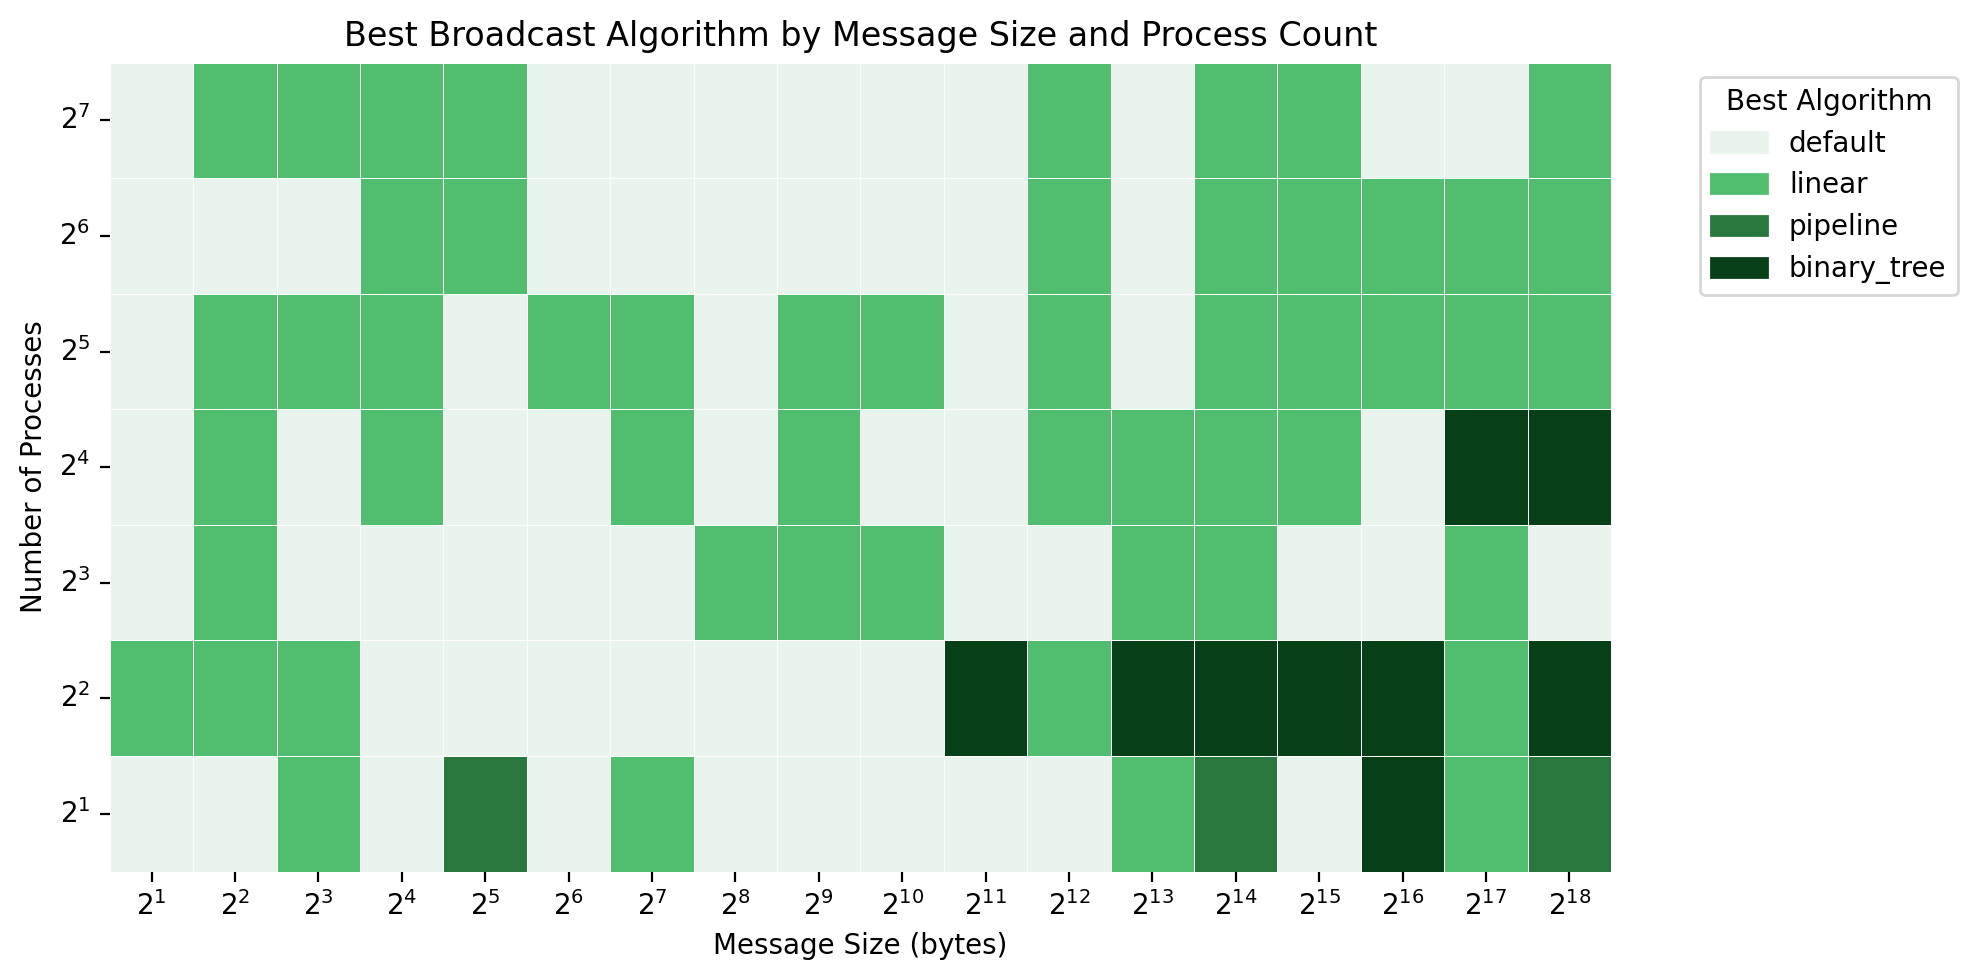

In [121]:
# Estraggo i DataFrame dal dict
df_b_map0 = bcast_varied['bcast0_core_mapping_genoa']   # default
df_b_map1 = bcast_varied['bcast1_core_mapping_genoa']   # basic linear
df_b_map3 = bcast_varied['bcast3_core_mapping_genoa']   # pipeline
df_b_map5 = bcast_varied['bcast5_core_mapping_genoa']   # binary tree

# Rinomino subito le colonne per chiarezza
df_b_map0 = df_b_map0.rename(columns={'Latency': 'Latency_default'})
df_b_map1 = df_b_map1.rename(columns={'Latency': 'Latency_linear'})
df_b_map3 = df_b_map3.rename(columns={'Latency': 'Latency_pipeline'})
df_b_map5 = df_b_map5.rename(columns={'Latency': 'Latency_binary_tree'})

# Merge su Processes e Size
merged_df = df_b_map0.merge(df_b_map1, on=['Processes', 'Size'])\
                     .merge(df_b_map3, on=['Processes', 'Size'])\
                     .merge(df_b_map5, on=['Processes', 'Size'])

# Trova algoritmo migliore per ogni cella
def best_algorithm(row):
    latencies = {
        'default': row['Latency_default'],
        'linear': row['Latency_linear'],
        'pipeline': row['Latency_pipeline'],
        'binary_tree': row['Latency_binary_tree']
    }
    return min(latencies, key=latencies.get)

merged_df['best_algorithm'] = merged_df.apply(best_algorithm, axis=1)

# Mappatura numerica per il plot
algorithm_mapping = {'default': 0, 'linear': 1, 'pipeline': 2, 'binary_tree': 3}
merged_df['algorithm_code'] = merged_df['best_algorithm'].map(algorithm_mapping)

# Pivot table (per heatmap)
heatmap_data = merged_df.pivot(index='Processes', columns='Size', values='algorithm_code')

# Palette colori personalizzata
cmap = sns.color_palette(["#e9f5ec", "#51bd6e", "#28783d", "#074016"])  # default, linear, pipeline, binary_tree

plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(heatmap_data, cmap=cmap, cbar=False, annot=False, fmt=".0f", linewidths=0.2)

plt.title('Best Broadcast Algorithm by Message Size and Process Count')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Number of Processes')
plt.gca().invert_yaxis()

# Tick formattati come potenze di 2
x_ticks = heatmap_data.columns
y_ticks = heatmap_data.index
plt.xticks(ticks=np.arange(len(x_ticks)) + 0.5,
           labels=[f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
plt.yticks(ticks=np.arange(len(y_ticks)) + 0.5,
           labels=[f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

# Legenda custom
legend_labels = list(algorithm_mapping.keys())
colors = [mpatches.Patch(color=cmap[i], label=legend_labels[i]) for i in range(len(cmap))]
plt.legend(handles=colors, title="Best Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'plots', 'best_broadcast_algorithm.png'))
plt.show()

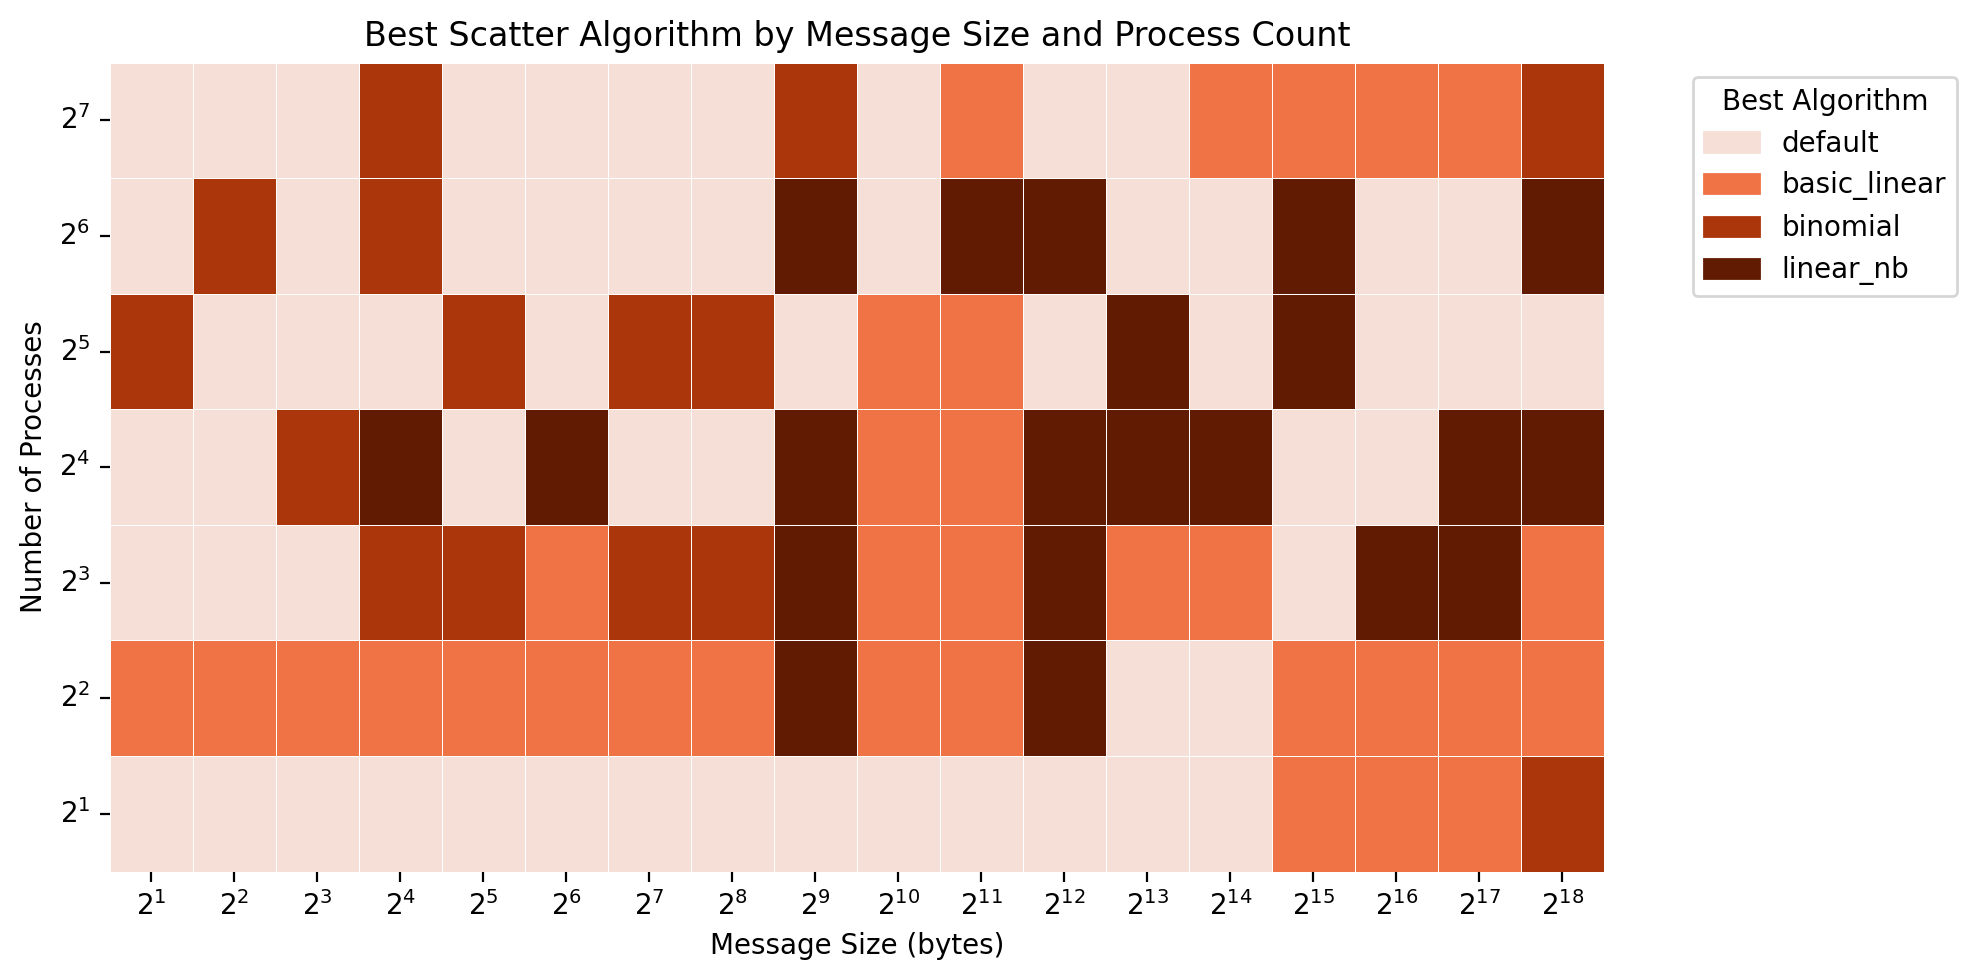

In [122]:
# Rinominare colonne per chiarezza
df_s_map0.rename(columns={'Latency': 'Latency_default'}, inplace=True)
df_s_map1.rename(columns={'Latency': 'Latency_basic_linear'}, inplace=True)
df_s_map2.rename(columns={'Latency': 'Latency_binomial'}, inplace=True)
df_s_map3.rename(columns={'Latency': 'Latency_linear_nb'}, inplace=True)

# Merge su Processes e Size
merged_df = df_s_map0.merge(df_s_map1, on=['Processes', 'Size']) \
                     .merge(df_s_map2, on=['Processes', 'Size']) \
                     .merge(df_s_map3, on=['Processes', 'Size'])

# Funzione per il miglior algoritmo
def best_algorithm(row):
    latencies = {
        'default': row['Latency_default'],
        'basic_linear': row['Latency_basic_linear'],
        'binomial': row['Latency_binomial'],
        'linear_nb': row['Latency_linear_nb']
    }
    return min(latencies, key=latencies.get)

merged_df['best_algorithm'] = merged_df.apply(best_algorithm, axis=1)

# Mappatura numerica per il plot
algorithm_mapping = {'default': 0, 'basic_linear': 1, 'binomial': 2, 'linear_nb': 3}
merged_df['algorithm_code'] = merged_df['best_algorithm'].map(algorithm_mapping)

# Pivot table (per heatmap)
heatmap_data = merged_df.pivot(index='Processes', columns='Size', values='algorithm_code')

# Palette colori personalizzata (cambia colori se vuoi!)
cmap = sns.color_palette(["#f5dfd7", "#f07346", "#ab360c", "#611b02"])  # default, basic_linear, binomial, linear_nb

plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(heatmap_data, cmap=cmap, cbar=False, annot=False, fmt=".0f", linewidths=0.2)

plt.title('Best Scatter Algorithm by Message Size and Process Count')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Number of Processes')
plt.gca().invert_yaxis()

# Tick formattati come potenze di 2
x_ticks = heatmap_data.columns
y_ticks = heatmap_data.index
plt.xticks(ticks=np.arange(len(x_ticks)) + 0.5,
           labels=[f'$2^{{{int(np.log2(x))}}}$' for x in x_ticks], rotation=0)
plt.yticks(ticks=np.arange(len(y_ticks)) + 0.5,
           labels=[f'$2^{{{int(np.log2(y))}}}$' for y in y_ticks], rotation=0)

# Legenda custom
legend_labels = list(algorithm_mapping.keys())
colors = [mpatches.Patch(color=cmap[i], label=legend_labels[i]) for i in range(len(cmap))]
plt.legend(handles=colors, title="Best Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'plots', 'best_scatter_algorithm.png'))
plt.show()

In [123]:
def map3d_grid(df_maps, titles, out, out_dir, colmap='viridis'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=200, subplot_kw={'projection': '3d'})
    axs = axs.flatten() 

    for i, (df_map, title) in enumerate(zip(df_maps, titles)):
        ax = axs[i]
        x = np.log2(df_map['Processes'])
        y = np.log2(df_map['Size'])
        # Cerca la colonna della latenza (qualunque sia il suffisso)
        latency_col = [c for c in df_map.columns if c.lower().startswith('latency')]
        assert latency_col, f"Nessuna colonna di latenza trovata in: {df_map.columns}"
        z = np.log2(df_map[latency_col[0]])
        
        xi = np.linspace(x.min(), x.max(), 50)
        yi = np.linspace(y.min(), y.max(), 50)
        xi, yi = np.meshgrid(xi, yi)

        surf = ax.plot_trisurf(x, y, z, cmap=colmap, edgecolor='black', alpha=0.8)
        ax.set_xlim(ax.get_xlim()[::-1])
        
        process_ticks = np.arange(x.min(), x.max() + 1, 1)
        size_ticks = np.arange(0, 19, 3)
        
        ax.set_xticks(process_ticks)
        ax.set_xticklabels([f"$2^{{{int(tick)}}}$" for tick in process_ticks])
        ax.set_yticks(size_ticks)
        ax.set_yticklabels([f"$2^{{{int(tick)}}}$" for tick in size_ticks])
        ax.view_init(elev=20, azim=320)
        ax.set_xlabel('Number of Processes', fontsize=7)
        ax.set_ylabel('Message Size (bytes)')
        
        mappable = cm.ScalarMappable(cmap=colmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
        mappable.set_array(z)
        fig.colorbar(mappable, ax=ax, label='$\\log_2$(Avg Latency $(\\mu s)$)', shrink=0.6, pad=0.15)
        ax.set_title(title)
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, out))
    plt.show()


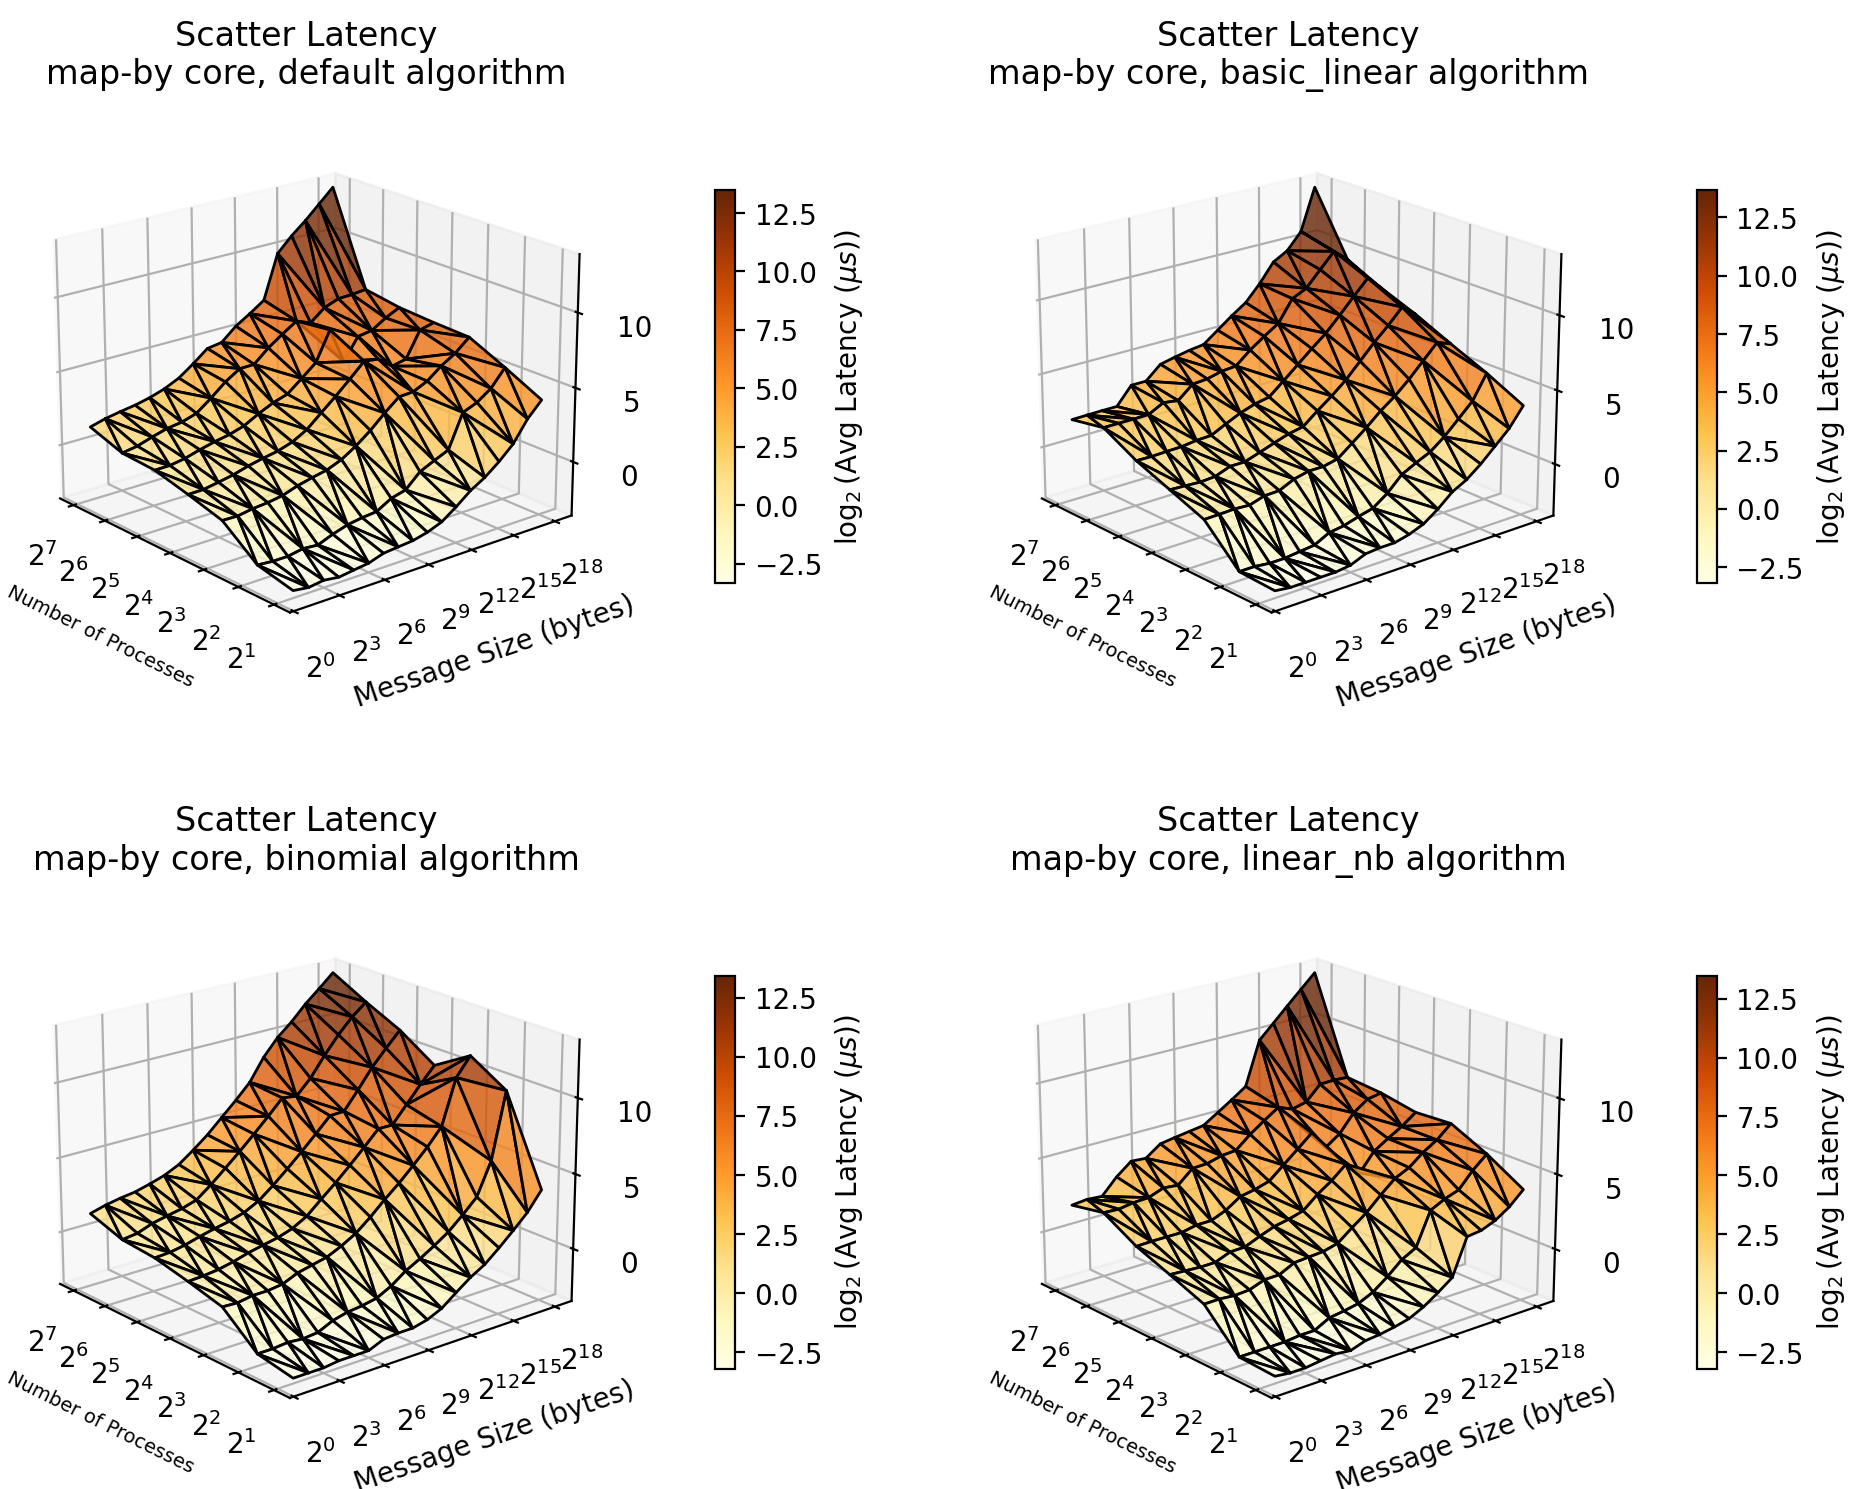

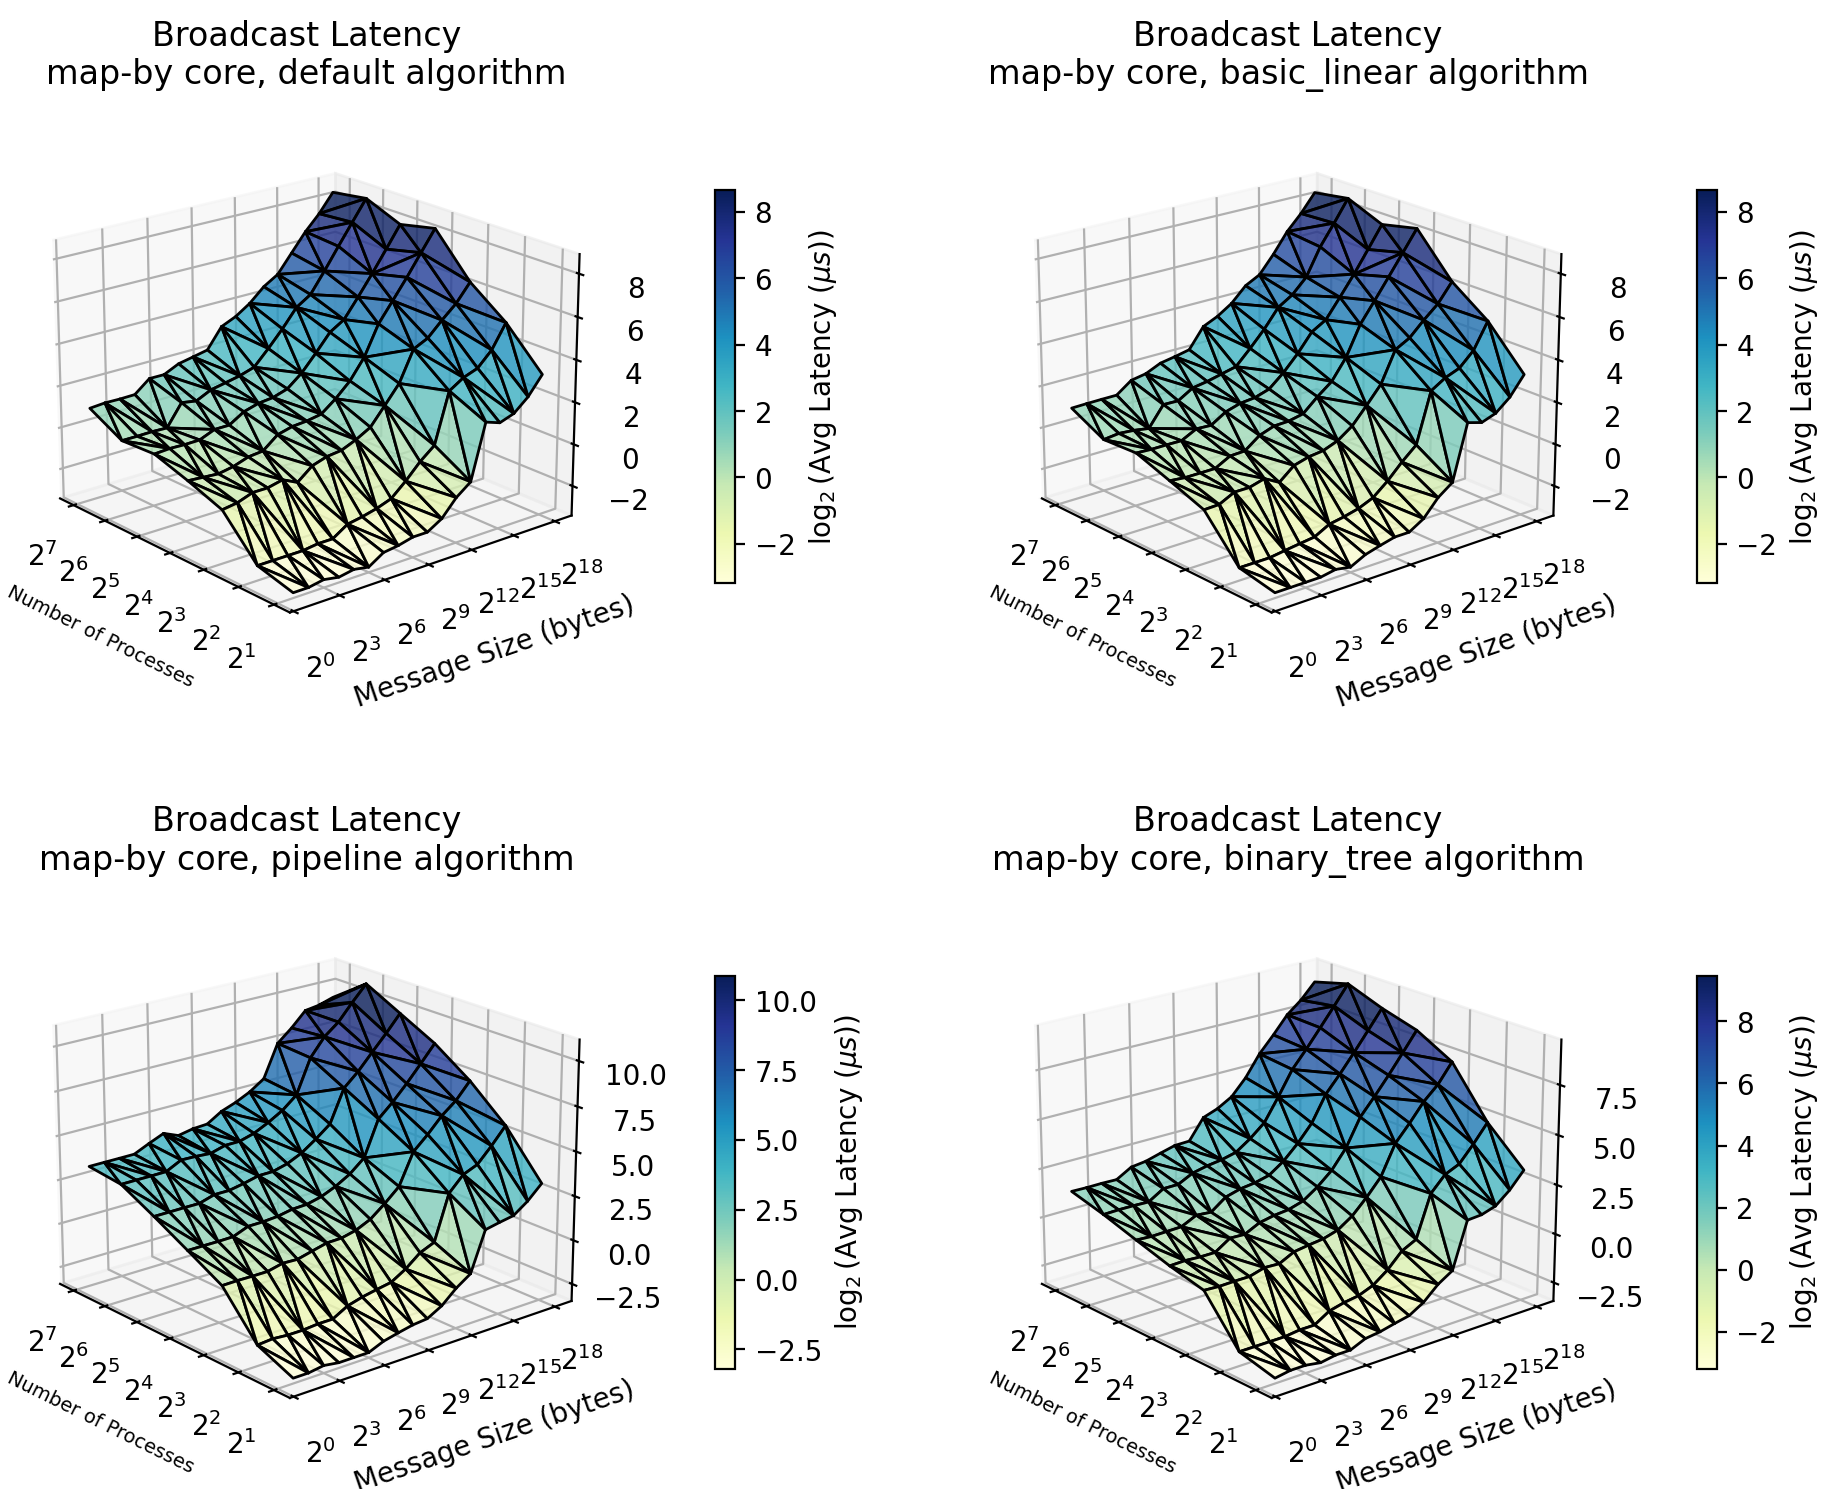

In [124]:
# Prendi sempre i DataFrame dai dict!

bc_df_maps = [
    bcast_varied['bcast0_core_mapping_genoa'],
    bcast_varied['bcast1_core_mapping_genoa'],
    bcast_varied['bcast3_core_mapping_genoa'],
    bcast_varied['bcast5_core_mapping_genoa'],
]
bc_titles = [
    "Broadcast Latency\nmap-by core, default algorithm",
    "Broadcast Latency\nmap-by core, basic_linear algorithm",
    "Broadcast Latency\nmap-by core, pipeline algorithm",
    "Broadcast Latency\nmap-by core, binary_tree algorithm"
]

sc_df_maps = [
    scatter_varied['scatter0_core_mapping'],
    scatter_varied['scatter1_core_mapping'],
    scatter_varied['scatter2_core_mapping'],
    scatter_varied['scatter3_core_mapping'],
]
sc_titles = [
    "Scatter Latency\nmap-by core, default algorithm",
    "Scatter Latency\nmap-by core, basic_linear algorithm",
    "Scatter Latency\nmap-by core, binomial algorithm",
    "Scatter Latency\nmap-by core, linear_nb algorithm"
]



# Cartella per output
plots_dir = os.path.join(BASE_DIR, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# Scatter
map3d_grid(sc_df_maps, sc_titles, 'scatter_map_by_core.png', plots_dir, 'YlOrBr')

# Broadcast
map3d_grid(bc_df_maps, bc_titles, 'broadcast_map_by_core.png', plots_dir, 'YlGnBu')

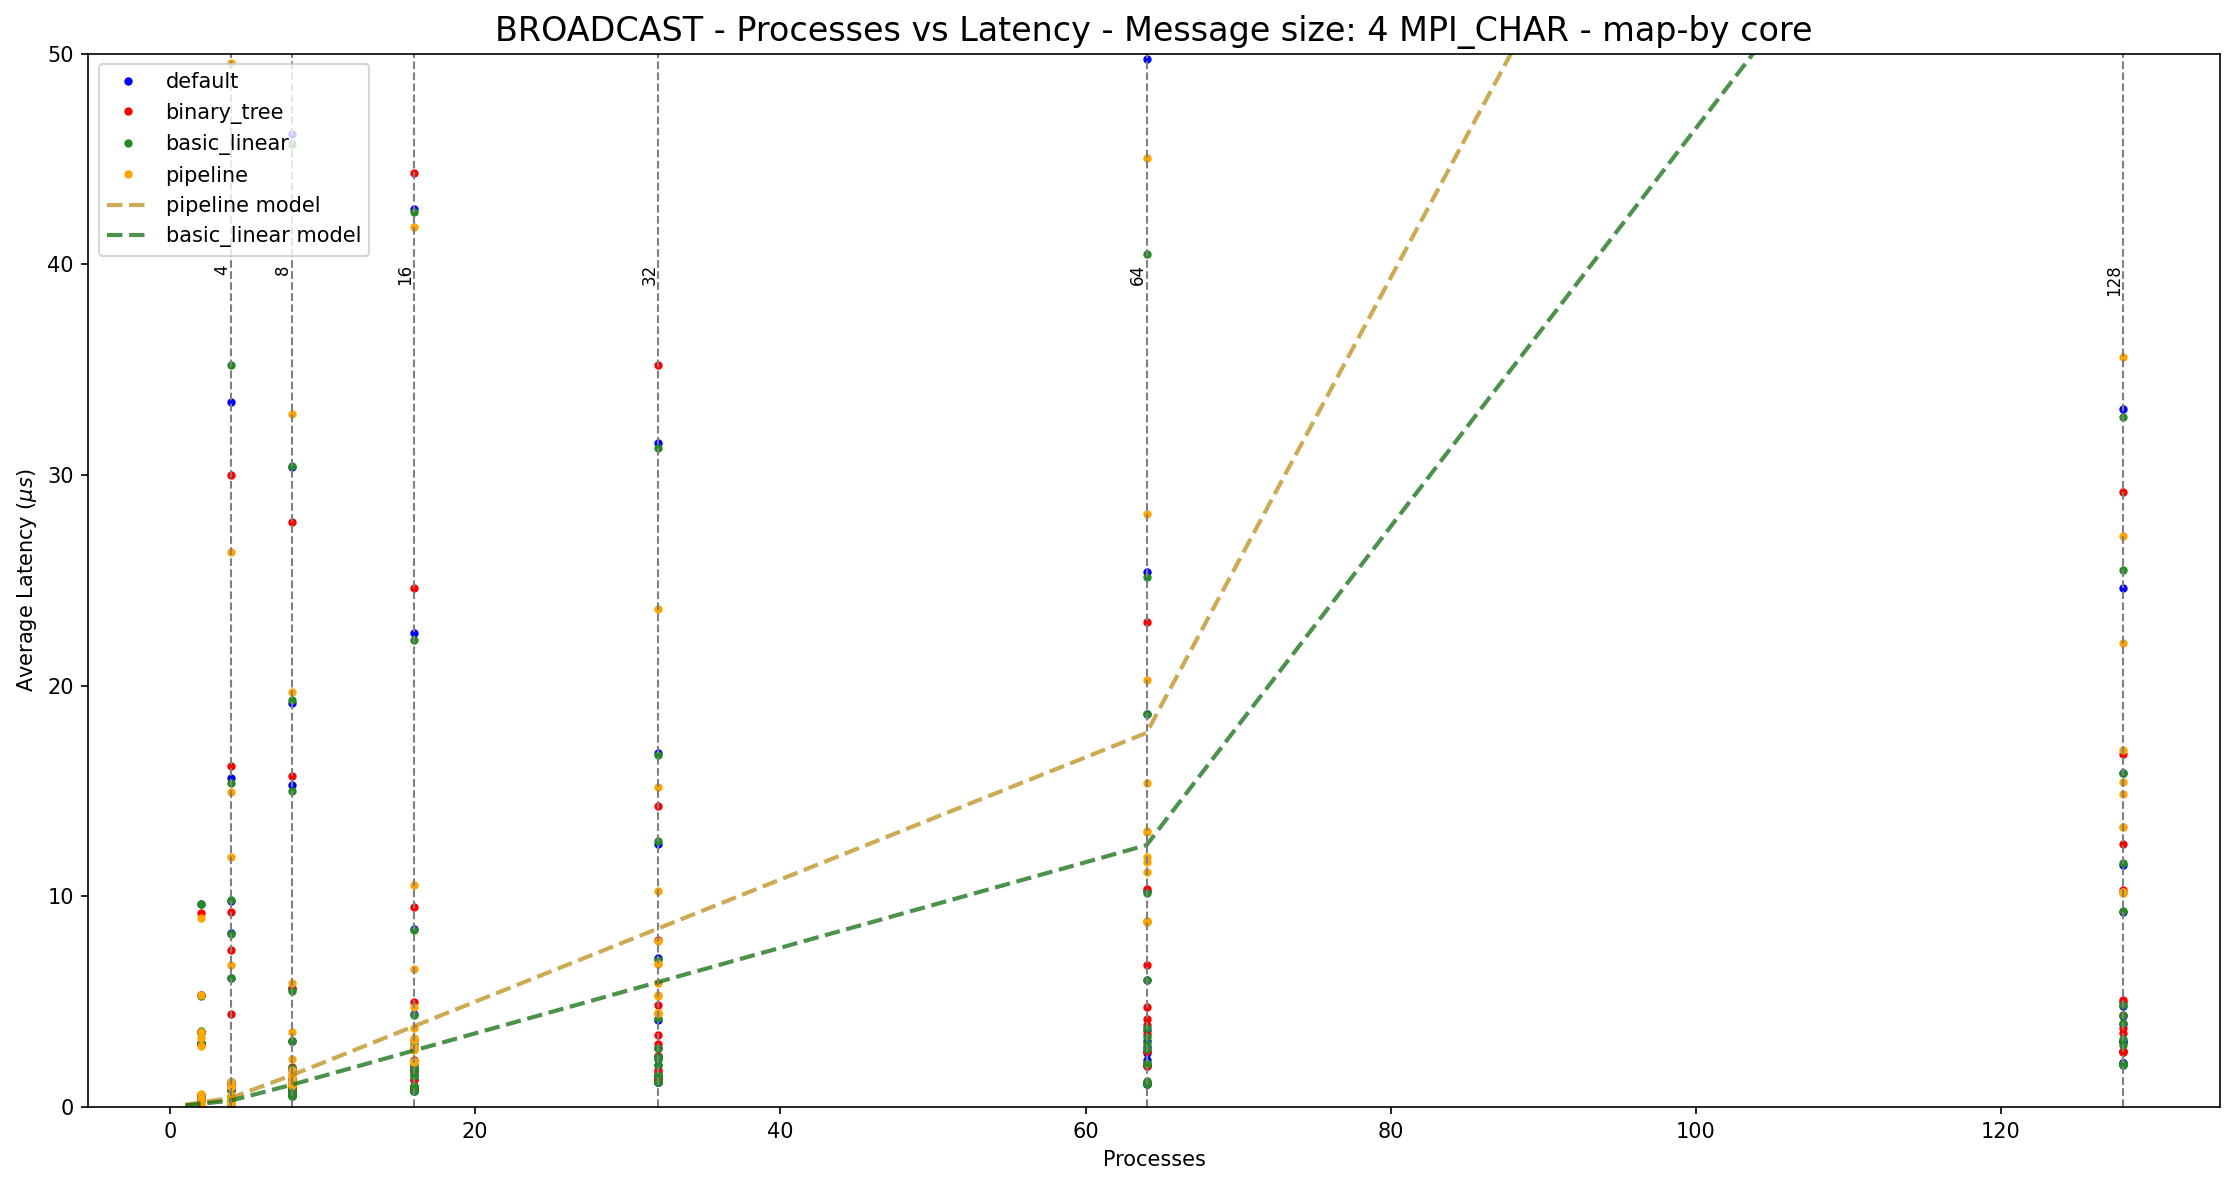

In [125]:
# --- PARAMETRI: latenze misurate dal tuo CSV (MessageSize=1) ---
LATENCY_CCX = 0.11                # Same CCX/CCD
LATENCY_CCD_DIFF_CCX = 0.27       # Same NUMA (different CCD)
LATENCY_NUMA = 0.29               # Same Socket (different NUMA)
LATENCY_SOCKET = 0.29             # (Stessa socket = stessa NUMA per questa architettura)
LATENCY_DIFF_SOCKET = 1.35        # Different Node (usato come approx)
LATENCY_DIFF_NODE = 1.35          # Different Node

latency_ccx = LATENCY_CCX
latency_ccd = LATENCY_CCD_DIFF_CCX
latency_numa = LATENCY_NUMA
latency_socket = LATENCY_DIFF_SOCKET  # Da 64+ in poi

MAX_PROC = 128
x = np.arange(1, MAX_PROC+1)  # [1, ..., 128]

def build_pipeline_model(n_proc, lat_ccx, lat_ccd, lat_numa, lat_socket):
    pipeline = []
    for i in range(1, n_proc+1):
        if i <= 4:
            latency = lat_ccx
        elif i <= 8:
            latency = lat_ccd
        elif i <= 64:
            latency = lat_numa
        else:
            latency = lat_socket
        if pipeline:
            pipeline.append(pipeline[-1] + latency)
        else:
            pipeline.append(latency)
    return np.array(pipeline)

def build_basic_linear_model(pipeline_model, discount=0.7):
    return pipeline_model * discount

pipeline_model = build_pipeline_model(MAX_PROC, latency_ccx, latency_ccd, latency_numa, latency_socket)
basic_linear_model = build_basic_linear_model(pipeline_model, discount=0.7)

plt.figure(figsize=(15, 8), dpi=150)

plt.plot(b_df0['Processes'], b_df0['Latency'], 'o', color='blue', label='default', markersize=3)
plt.plot(b_df5['Processes'], b_df5['Latency'], 'o', color='red', label='binary_tree', markersize=3)
plt.plot(b_df1['Processes'], b_df1['Latency'], 'o', color='forestgreen', label='basic_linear', markersize=3)
plt.plot(b_df3['Processes'], b_df3['Latency'], 'o', color='orange', label='pipeline', markersize=3)

plt.plot(x, pipeline_model, '--', color='darkgoldenrod', linewidth=2, label='pipeline model', alpha=0.7)
plt.plot(x, basic_linear_model, '--', color='darkgreen', linewidth=2, label='basic_linear model', alpha=0.7)

for i in range(2, 8):   # 4, 8, 16, 32, 64, 128
    val = 2**i
    plt.axvline(x=val, color='grey', linestyle='--', linewidth=1)
    plt.text(val, 40, f'{val}', ha='right', va='top', rotation=90, fontsize=8, color='black')

plt.xlabel('Processes')
plt.ylabel('Average Latency ($\\mu s$)')
plt.title('BROADCAST - Processes vs Latency - Message size: 4 MPI_CHAR - map-by core', size=16)
plt.legend(loc='upper left')
plt.ylim(0, 50)  # <--- Limita l'asse y a 50 μs
plt.tight_layout()
plt.show()


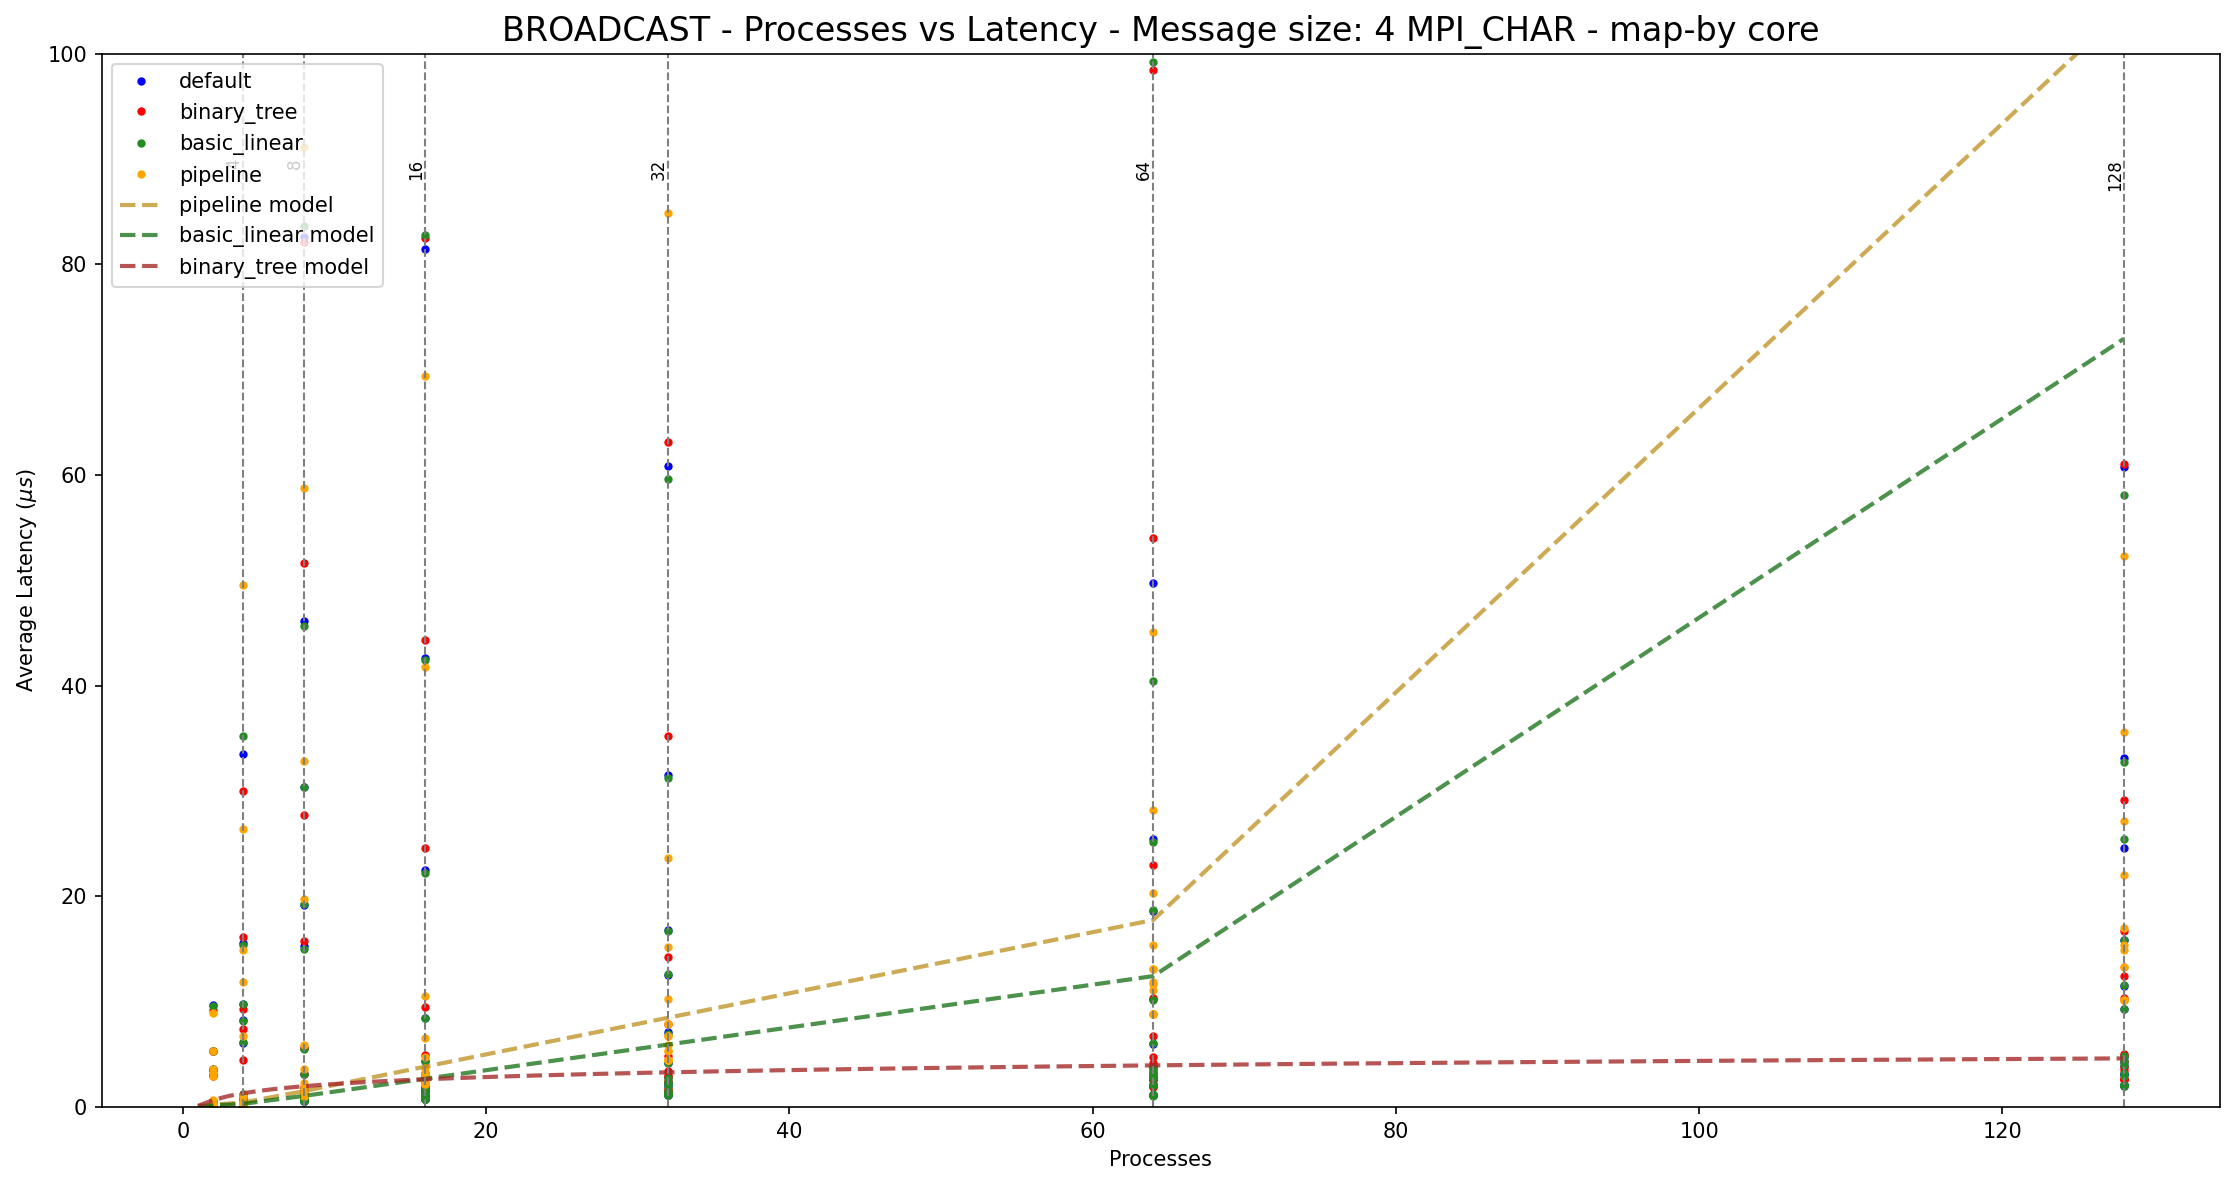

In [126]:

# --- PARAMETRI: latenze misurate dal tuo CSV (MessageSize=1) ---
LATENCY_CCX = 0.11                # Same CCX/CCD
LATENCY_CCD_DIFF_CCX = 0.27       # Same NUMA (different CCD)
LATENCY_NUMA = 0.29               # Same Socket (different NUMA)
LATENCY_SOCKET = 0.29             # (Stessa socket = stessa NUMA per questa architettura)
LATENCY_DIFF_SOCKET = 1.35        # Different Node (usato come approx)
LATENCY_DIFF_NODE = 1.35          # Different Node

latency_ccx = LATENCY_CCX
latency_ccd = LATENCY_CCD_DIFF_CCX
latency_numa = LATENCY_NUMA
latency_socket = LATENCY_DIFF_SOCKET  # Da 64+ in poi

MAX_PROC = 128
x = np.arange(1, MAX_PROC+1)  # [1, ..., 128]

def build_pipeline_model(n_proc, lat_ccx, lat_ccd, lat_numa, lat_socket):
    pipeline = []
    for i in range(1, n_proc+1):
        if i <= 4:
            latency = lat_ccx
        elif i <= 8:
            latency = lat_ccd
        elif i <= 64:
            latency = lat_numa
        else:
            latency = lat_socket
        if pipeline:
            pipeline.append(pipeline[-1] + latency)
        else:
            pipeline.append(latency)
    return np.array(pipeline)

def build_basic_linear_model(pipeline_model, discount=0.7):
    return pipeline_model * discount

def build_binary_tree_model(n_proc, base_latency=LATENCY_CCX):
    """Modello base: la profondità dell'albero è log2(n_proc)"""
    return np.array([np.log2(p) * base_latency * 6 if p > 1 else base_latency for p in range(1, n_proc+1)])

pipeline_model = build_pipeline_model(MAX_PROC, LATENCY_CCX, LATENCY_CCD_DIFF_CCX, LATENCY_NUMA, LATENCY_DIFF_SOCKET)
basic_linear_model = build_basic_linear_model(pipeline_model, discount=0.7)
binary_tree_model = build_binary_tree_model(MAX_PROC, base_latency=LATENCY_CCX)

plt.figure(figsize=(15, 8), dpi=150)

# Sostituisci questi DataFrame con i tuoi dati!
plt.plot(b_df0['Processes'], b_df0['Latency'], 'o', color='blue', label='default', markersize=3)
plt.plot(b_df5['Processes'], b_df5['Latency'], 'o', color='red', label='binary_tree', markersize=3)
plt.plot(b_df1['Processes'], b_df1['Latency'], 'o', color='forestgreen', label='basic_linear', markersize=3)
plt.plot(b_df3['Processes'], b_df3['Latency'], 'o', color='orange', label='pipeline', markersize=3)

plt.plot(x, pipeline_model, '--', color='darkgoldenrod', linewidth=2, label='pipeline model', alpha=0.7)
plt.plot(x, basic_linear_model, '--', color='darkgreen', linewidth=2, label='basic_linear model', alpha=0.7)
plt.plot(x, binary_tree_model, '--', color='brown', linewidth=2, label='binary_tree model', alpha=0.8)

for i in range(2, 8):
    val = 2**i
    plt.axvline(x=val, color='grey', linestyle='--', linewidth=1)
    plt.text(val, 90, f'{val}', ha='right', va='top', rotation=90, fontsize=8, color='black')

plt.xlabel('Processes')
plt.ylabel('Average Latency ($\\mu s$)')
plt.title('BROADCAST - Processes vs Latency - Message size: 4 MPI_CHAR - map-by core', size=16)
plt.legend(loc='upper left')
plt.ylim(0, 100)   # Y fino a 100
plt.tight_layout()
plt.show()



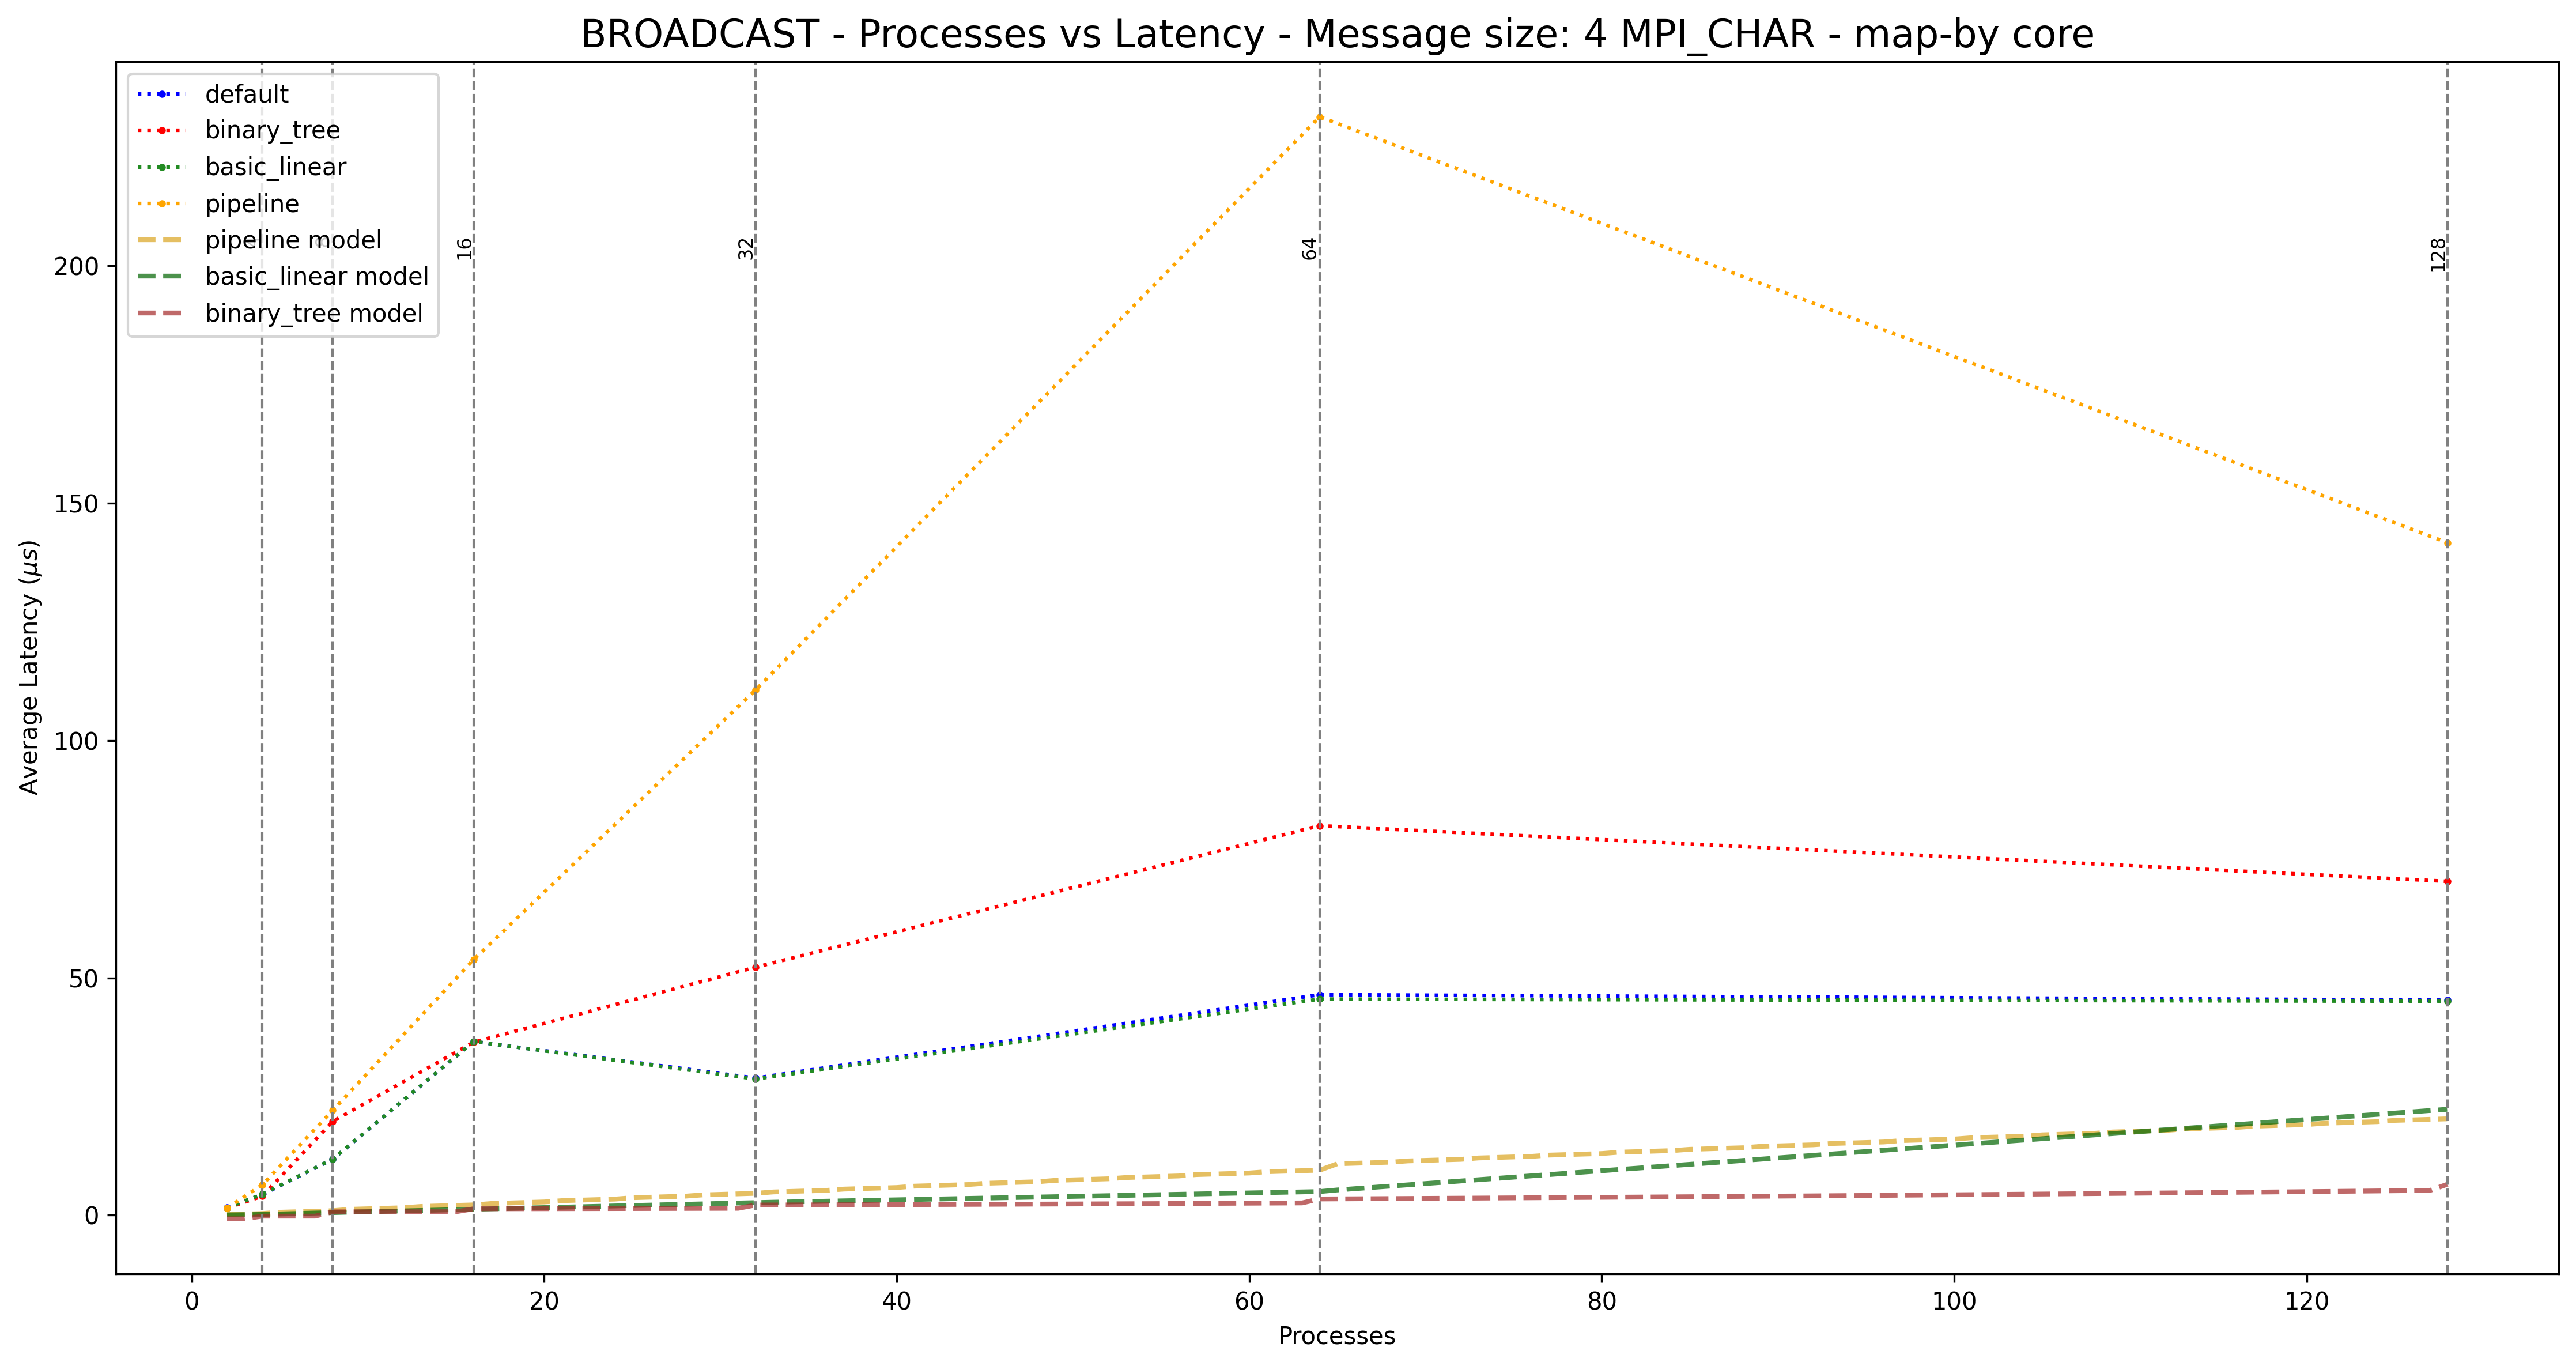

In [130]:
# -----------------------------------------------------------------------------
# 1) Configurazione dei path e lettura dei dati di latenza point-to-point
# -----------------------------------------------------------------------------
SCRIPTS_DIR = os.path.expanduser('~/HPC-project/ex1/scripts')
P2P_CSV     = os.path.join(SCRIPTS_DIR, 'latency_pt2pt.csv')

# leggi tutto il CSV
p2p_df = pd.read_csv(P2P_CSV)

# mantieni solo le righe “vere” con MessageSize numerico
p2p_df = p2p_df[p2p_df['MessageSize'].apply(lambda x: str(x).isdigit())]
p2p_df['MessageSize'] = p2p_df['MessageSize'].astype(int)
p2p_df['Latency_us' ] = p2p_df['Latency_us' ].astype(float)

# prendi la latenza media per ognuno dei 4 casi, solo per MessageSize==1
lat1 = p2p_df[p2p_df['MessageSize']==1].groupby('Label')['Latency_us'].median()

LATENCY_CCX                = float(lat1['Same CCX'])
LATENCY_CCD_DIFF_CCX       = float(lat1['Same NUMA (different CCD)'])
LATENCY_NUMA               = float(lat1['Same Socket (different NUMA)'])
# non hai misurato “Different Socket” puro: lo approssimo col nodo
LATENCY_DIFF_NODE          = float(lat1['Different Node'])
LATENCY_DIFF_SOCKET        = LATENCY_DIFF_NODE
# per semplicità considero same_SOCKET = same_NUMA nella tua architettura
LATENCY_SOCKET             = LATENCY_NUMA

# dizionario in microsecondi
latency_p2p = {
    "same_CCX":                LATENCY_CCX,
    "same_CCD_different_CCX":  LATENCY_CCD_DIFF_CCX,
    "same_NUMA":               LATENCY_NUMA,
    "same_SOCKET":             LATENCY_SOCKET,
    "different_SOCKET":        LATENCY_DIFF_SOCKET,
    "different_NODE":          LATENCY_DIFF_NODE,
}

# -----------------------------------------------------------------------------
# 2) Definizione dei modelli analitici
# -----------------------------------------------------------------------------
def determine_latency(i, j):
    """Restituisce in µs la latenza fra core i e core j contigui secondo topologia EPYC."""
    if i // 4   == j // 4:   return latency_p2p["same_CCX"]
    if i // 8   == j // 8:   return latency_p2p["same_CCD_different_CCX"]
    if i // 16  == j // 16:  return latency_p2p["same_NUMA"]
    if i // 64  == j // 64:  return latency_p2p["same_SOCKET"]
    if i // 128 == j // 128: return latency_p2p["different_SOCKET"]
    return latency_p2p["different_NODE"]

def par_disc(i):
    """Sconto di parallelismo per il modello basic_linear."""
    if   i < 4:   return 0.40
    elif i < 8:   return 0.35
    elif i < 32:  return 0.30
    elif i < 64:  return 0.25
    elif i < 128: return 0.20
    else:         return 0.12

def calculate_latency(n):
    """Modello pipeline: somma dei n-1 hop in linea retta."""
    return sum(determine_latency(i, i+1) for i in range(n-1))

def calculate_bs_latency(n):
    """Modello basic_linear: sconto di par_disc su ogni hop dal root."""
    return sum(determine_latency(0, i+1)*par_disc(i) for i in range(n-1))

# costruiamo i vettori di lunghezza MAX_PROC-1 (per x=2..MAX_PROC)
MAX_PROC = 128
x = np.arange(2, MAX_PROC+1)        # array([  2,   3, ..., 128])

pip_model    = np.array([calculate_latency(n)     for n in x])
bs_lin_model = np.array([calculate_bs_latency(n)  for n in x])

# -----------------------------------------------------------------------------
# 3) Modello albero binario (facoltativo, se hai già la funzione bin_tree_latency)
# -----------------------------------------------------------------------------
# se vuoi includerlo, puoi riciclare esattamente il tuo bin_tree_latency ma
# facendo attenzione alle unità di misura (qui usiamo microsecondi), e infine:
# binary_tree_model = np.array([bin_tree_latency(n) for n in x])
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 4) Caricamento dei dati sperimentali di broadcast (fissi e varied)
# -----------------------------------------------------------------------------
# assumo che tu abbia già in memoria i DataFrame b_df0, b_df1, b_df3, b_df5:
#   b_df0 = bcast_varied['bcast0_core_mapping_genoa']
#   b_df1 = bcast_varied['bcast1_core_mapping_genoa']
#   b_df3 = bcast_varied['bcast3_core_mapping_genoa']
#   b_df5 = bcast_varied['bcast5_core_mapping_genoa']
#
# assicurati che tutti abbiano:
#   • colonna “Processes” ordinata crescente
#   • colonna “Latency” in float (µs)
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# Plottaggio: scatter reali + linee modelli + verticali sulle potenze di 2
# -----------------------------------------------------------------------------
# Raggruppa per numero di processi e calcola la media
b_df0 = b_df0.groupby('Processes', as_index=False)['Latency'].mean()
b_df1 = b_df1.groupby('Processes', as_index=False)['Latency'].mean()
b_df3 = b_df3.groupby('Processes', as_index=False)['Latency'].mean()
b_df5 = b_df5.groupby('Processes', as_index=False)['Latency'].mean()

# Ordino i DataFrame per evitare l'effetto "a sega"
b_df0 = b_df0.sort_values(by='Processes')
b_df1 = b_df1.sort_values(by='Processes')
b_df3 = b_df3.sort_values(by='Processes')
b_df5 = b_df5.sort_values(by='Processes')

# Imposto il plot
plt.figure(figsize=(15, 8), dpi=300)

# Latenze sperimentali con linee puntinate
plt.plot(b_df0['Processes'], b_df0['Latency'], linestyle=':', marker='o', color='blue', markersize=2, label='default')
plt.plot(b_df5['Processes'], b_df5['Latency'], linestyle=':', marker='o', color='red', markersize=2, label='binary_tree')
plt.plot(b_df1['Processes'], b_df1['Latency'], linestyle=':', marker='o', color='forestgreen', markersize=2, label='basic_linear')
plt.plot(b_df3['Processes'], b_df3['Latency'], linestyle=':', marker='o', color='orange', markersize=2, label='pipeline')

# Modelli teorici
plt.plot(x, pip_model, linestyle='--', color='goldenrod', linewidth=2, label='pipeline model', alpha=0.7)
plt.plot(x, bs_lin_model, linestyle='--', color='darkgreen', linewidth=2, label='basic_linear model', alpha=0.7)
plt.plot(x, binary_tree_latencies[:len(x)], linestyle='--', color='brown', linewidth=2, label='binary_tree model', alpha=0.7)

# Linee verticali su potenze di 2
for i in range(2, 8):
    val = 2**i
    plt.axvline(x=val, color='grey', linestyle='--', linewidth=1)
    plt.text(val, plt.ylim()[1]*0.85, f'{val}', ha='right', va='top', rotation=90, fontsize=8)

# Titoli e legende
plt.xlabel('Processes')
plt.ylabel('Average Latency ($\\mu s$)')
plt.title('BROADCAST - Processes vs Latency - Message size: 4 MPI_CHAR - map-by core', size=16)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

